# PROJECT PIPELINE: MACHINE LEARNING–BASED ANALYSIS AND COMPARISON OF SPECIFIC CAPACITANCE FROM CV AND GCD

## 1. ENVIRONMENT SETUP AND DEPENDENCIES

### 1.1 VIRTUAL ENVIRONMENT PACKAGES (REQUIREMENTS.TXT)

THE FOLLOWING PACKAGES MUST BE INSTALLED IN YOUR VENV TO RUN THIS PIPELINE:

- PANDAS>=1.5.0
- NUMPY>=1.23.0
- MATPLOTLIB>=3.6.0
- SEABORN>=0.12.0
- SCIKIT-LEARN>=1.2.0
- XGBOOST>=1.7.0
- LIGHTGBM>=3.3.0
- SHAP>=0.41.0
- SCIPY>=1.9.0

### 1.2 GLOBAL IMPORTS AND VISUALIZATION STANDARDS

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats

warnings.filterwarnings('ignore')

In [37]:
# -----------------------------------------------------------------------------
# GLOBAL VISUALIZATION STANDARDS
# -----------------------------------------------------------------------------
plt.rcParams.update({
    'figure.figsize': (8, 6),
    'figure.dpi': 500,
    'axes.grid': True,
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'font.size': 12
})

## 2. DATA LOADING AND VALIDATION

### 2.1 LOAD DATASETS, CLEAN UNNAMED COLUMNS, AND DISPLAY SHAPE

In [ ]:
def load_and_clean_data(cv_path: str, gcd_path: str) -> tuple:
    """
    LOADS CV AND GCD DATASETS, REMOVES UNNAMED COLUMNS,
    AND DISPLAYS BASIC SHAPE AND HEAD INFO.
    
    PARAMETERS:
    - cv_path: STRING PATH TO CV CSV
    - gcd_path: STRING PATH TO GCD CSV
    
    RETURNS:
    - TUPLE OF (CV_DATAFRAME, GCD_DATAFRAME)
    """
    cv_df = pd.read_csv(cv_path)
    gcd_df = pd.read_csv(gcd_path)
    
    # DROP UNNAMED COLUMNS IN CV DATA
    cv_df = cv_df.loc[:, ~cv_df.columns.str.contains('^Unnamed')]
    
    print("=== CV DATASET SHAPE ===")
    print(cv_df.shape)
    print("\n=== CV DATASET HEAD ===")
    display(cv_df.head())
    
    print("\n=== GCD DATASET SHAPE ===")
    print(gcd_df.shape)
    print("\n=== GCD DATASET HEAD ===")
    display(gcd_df.head())
    
    return cv_df, gcd_df

# EXECUTE DATA LOADING
cv_df, gcd_df = load_and_clean_data(
    '../../DATASET/DATA/KOH/AL203-1M-KOH-CV.csv',
    '../../DATASET/DATA/KOH/AL203-1M-KOH-GCD.csv'
)

=== CV DATASET SHAPE ===
(8752, 5)

=== CV DATASET HEAD ===


Scan_Rate  Potential  Current     Area        CS
0        100   -0.29984 -0.51050  2.41787  60.44685
1        100   -0.29885 -0.41119  2.41787  60.44685
2        100   -0.29786 -0.34692  2.41787  60.44685
3        100   -0.29380 -0.19546  2.41787  60.44685
4        100   -0.29284 -0.17072  2.41787  60.44685


=== GCD DATASET SHAPE ===
(3944, 5)

=== GCD DATASET HEAD ===


Current_Density          Time  Potential  Discharge_Time   GCD_CS
0              5.0 -3.170000e-07   -0.15928         2.88868  36.1085
1              5.0  1.000000e-01   -0.08898         2.88868  36.1085
2              5.0  2.000000e-01   -0.07416         2.88868  36.1085
3              5.0  3.000000e-01   -0.06734         2.88868  36.1085
4              5.0  4.000000e-01   -0.06165         2.88868  36.1085

### 2.2 VALIDATE MISSING VALUES, DUPLICATES, AND CS RANGE

In [39]:
def validate_data(df: pd.DataFrame, dataset_name: str, target_col: str):
    """
    CHECKS FOR MISSING VALUES, DUPLICATES, OUTLIERS, 
    AND VALIDATES TARGET VARIABLE (Cs) RANGE.
    """
    print(f"\n{'='*40}")
    print(f"DATA VALIDATION: {dataset_name.upper()}")
    print(f"{'='*40}")
    
    # MISSING VALUES
    missing_count = df.isnull().sum().sum()
    print(f"TOTAL MISSING VALUES: {missing_count}")
    
    # DUPLICATES
    duplicate_count = df.duplicated().sum()
    print(f"TOTAL DUPLICATE ROWS: {duplicate_count}")
    
    # VALIDATE CS (SPECIFIC CAPACITANCE)
    if target_col in df.columns:
        print(f"\n{target_col.upper()} (TARGET) SUMMARY STATISTICS:")
        display(df[target_col].describe())
        
        # OUTLIER DETECTION VIA Z-SCORE
        z_scores = np.abs(stats.zscore(df[target_col].dropna()))
        outliers = np.where(z_scores > 3)[0]
        print(f"DETECTED OUTLIERS IN {target_col.upper()} (Z > 3): {len(outliers)}")
    else:
        print(f"TARGET COLUMN '{target_col}' NOT FOUND.")

validate_data(cv_df, "CV Dataset", "CS")
validate_data(gcd_df, "GCD Dataset", "GCD_CS")


DATA VALIDATION: CV DATASET
TOTAL MISSING VALUES: 0
TOTAL DUPLICATE ROWS: 0

CS (TARGET) SUMMARY STATISTICS:


count    8752.000000
mean       71.759403
std         7.996925
min        60.446850
25%        64.487200
50%        70.618030
75%        78.711160
max        86.419420
Name: CS, dtype: float64

DETECTED OUTLIERS IN CS (Z > 3): 0

DATA VALIDATION: GCD DATASET
TOTAL MISSING VALUES: 0
TOTAL DUPLICATE ROWS: 0

GCD_CS (TARGET) SUMMARY STATISTICS:


count    3944.000000
mean       45.440003
std         3.206760
min        36.108500
25%        44.553500
50%        46.711120
75%        47.745620
max        47.745620
Name: GCD_CS, dtype: float64

DETECTED OUTLIERS IN GCD_CS (Z > 3): 0


## 3. FEATURE ENGINEERING AND MERGING

### 3.1 STANDARDIZE COLUMNS AND DERIVE ELECTROCHEMICAL FEATURES

In [40]:
def engineer_features(cv_df: pd.DataFrame, gcd_df: pd.DataFrame) -> pd.DataFrame:
    """
    STANDARDIZES COLUMN NAMES, CREATES METHOD FLAGS, 
    DERIVES NEW ELECTROCHEMICAL FEATURES, AND MERGES BOTH DATASETS.
    """
    # 1. RENAME TARGET AND COMMON COLUMNS
    cv_clean = cv_df.rename(columns={'CS': 'Cs'})
    gcd_clean = gcd_df.rename(columns={'GCD_CS': 'Cs'})
    
    # 2. METHOD FLAGS
    cv_clean['Method'] = 'CV'
    gcd_clean['Method'] = 'GCD'
    
    # 3. DERIVE CURRENT DENSITY FOR CV
    # A = Area, I = Current
    # Current Density (A/g or A/cm2) = I / A
    cv_clean['Current_Density'] = cv_clean['Current'] / cv_clean['Area']
    
    # 4. POTENTIAL WINDOW CALCULATION
    cv_clean['Potential_Window'] = cv_clean.groupby('Scan_Rate')['Potential'].transform(lambda x: x.max() - x.min())
    gcd_clean['Potential_Window'] = gcd_clean.groupby('Current_Density')['Potential'].transform(lambda x: x.max() - x.min())
    
    # 5. MERGE DATASETS
    # WE CONCATENATE THE COMMON COLUMNS FOR CROSS-METHOD ANALYSIS
    common_cols = ['Potential', 'Current_Density', 'Cs', 'Method', 'Potential_Window']
    
    # KEEPING DOMAIN SPECIFIC COLUMNS PADDED WITH NAN
    unified_df = pd.concat([cv_clean, gcd_clean], ignore_index=True)
    
    print("=== UNIFIED DATASET SHAPE ===")
    print(unified_df.shape)
    
    return unified_df, cv_clean, gcd_clean

unified_df, cv_clean, gcd_clean = engineer_features(cv_df, gcd_df)

=== UNIFIED DATASET SHAPE ===
(12696, 10)


In [41]:
unified_df

Scan_Rate  Potential  Current     Area        Cs Method  \
0          100.0   -0.29984 -0.51050  2.41787  60.44685     CV   
1          100.0   -0.29885 -0.41119  2.41787  60.44685     CV   
2          100.0   -0.29786 -0.34692  2.41787  60.44685     CV   
3          100.0   -0.29380 -0.19546  2.41787  60.44685     CV   
4          100.0   -0.29284 -0.17072  2.41787  60.44685     CV   
...          ...        ...      ...      ...       ...    ...   
12691        NaN   -0.28868      NaN      NaN  47.74562    GCD   
12692        NaN   -0.29243      NaN      NaN  47.74562    GCD   
12693        NaN   -0.29627      NaN      NaN  47.74562    GCD   
12694        NaN   -0.29904      NaN      NaN  47.74562    GCD   
12695        NaN   -0.29990      NaN      NaN  47.74562    GCD   

       Current_Density  Potential_Window      Time  Discharge_Time  
0            -0.211136           0.40035       NaN             NaN  
1            -0.170063           0.40035       NaN             NaN  
2            -0.143482           0.40035       NaN             NaN  
3            -0.080840           0.40035       NaN             NaN  
4            -0.070608           0.40035       NaN             NaN  
...                ...               ...       ...             ...  
12691         0.250000           0.39971  180.3960          76.393  
12692         0.250000           0.39971  180.4960          76.393  
12693         0.250000           0.39971  180.5960          76.393  
12694         0.250000           0.39971  180.6396          76.393  
12695         0.250000           0.39971  180.6398          76.393  

[12696 rows x 10 columns]

## 4. EXTENSIVE EXPLORATORY DATA ANALYSIS (EDA)

### 4.1 DISTRIBUTION AND COMPARISON OF TARGET VARIABLE (Cs)

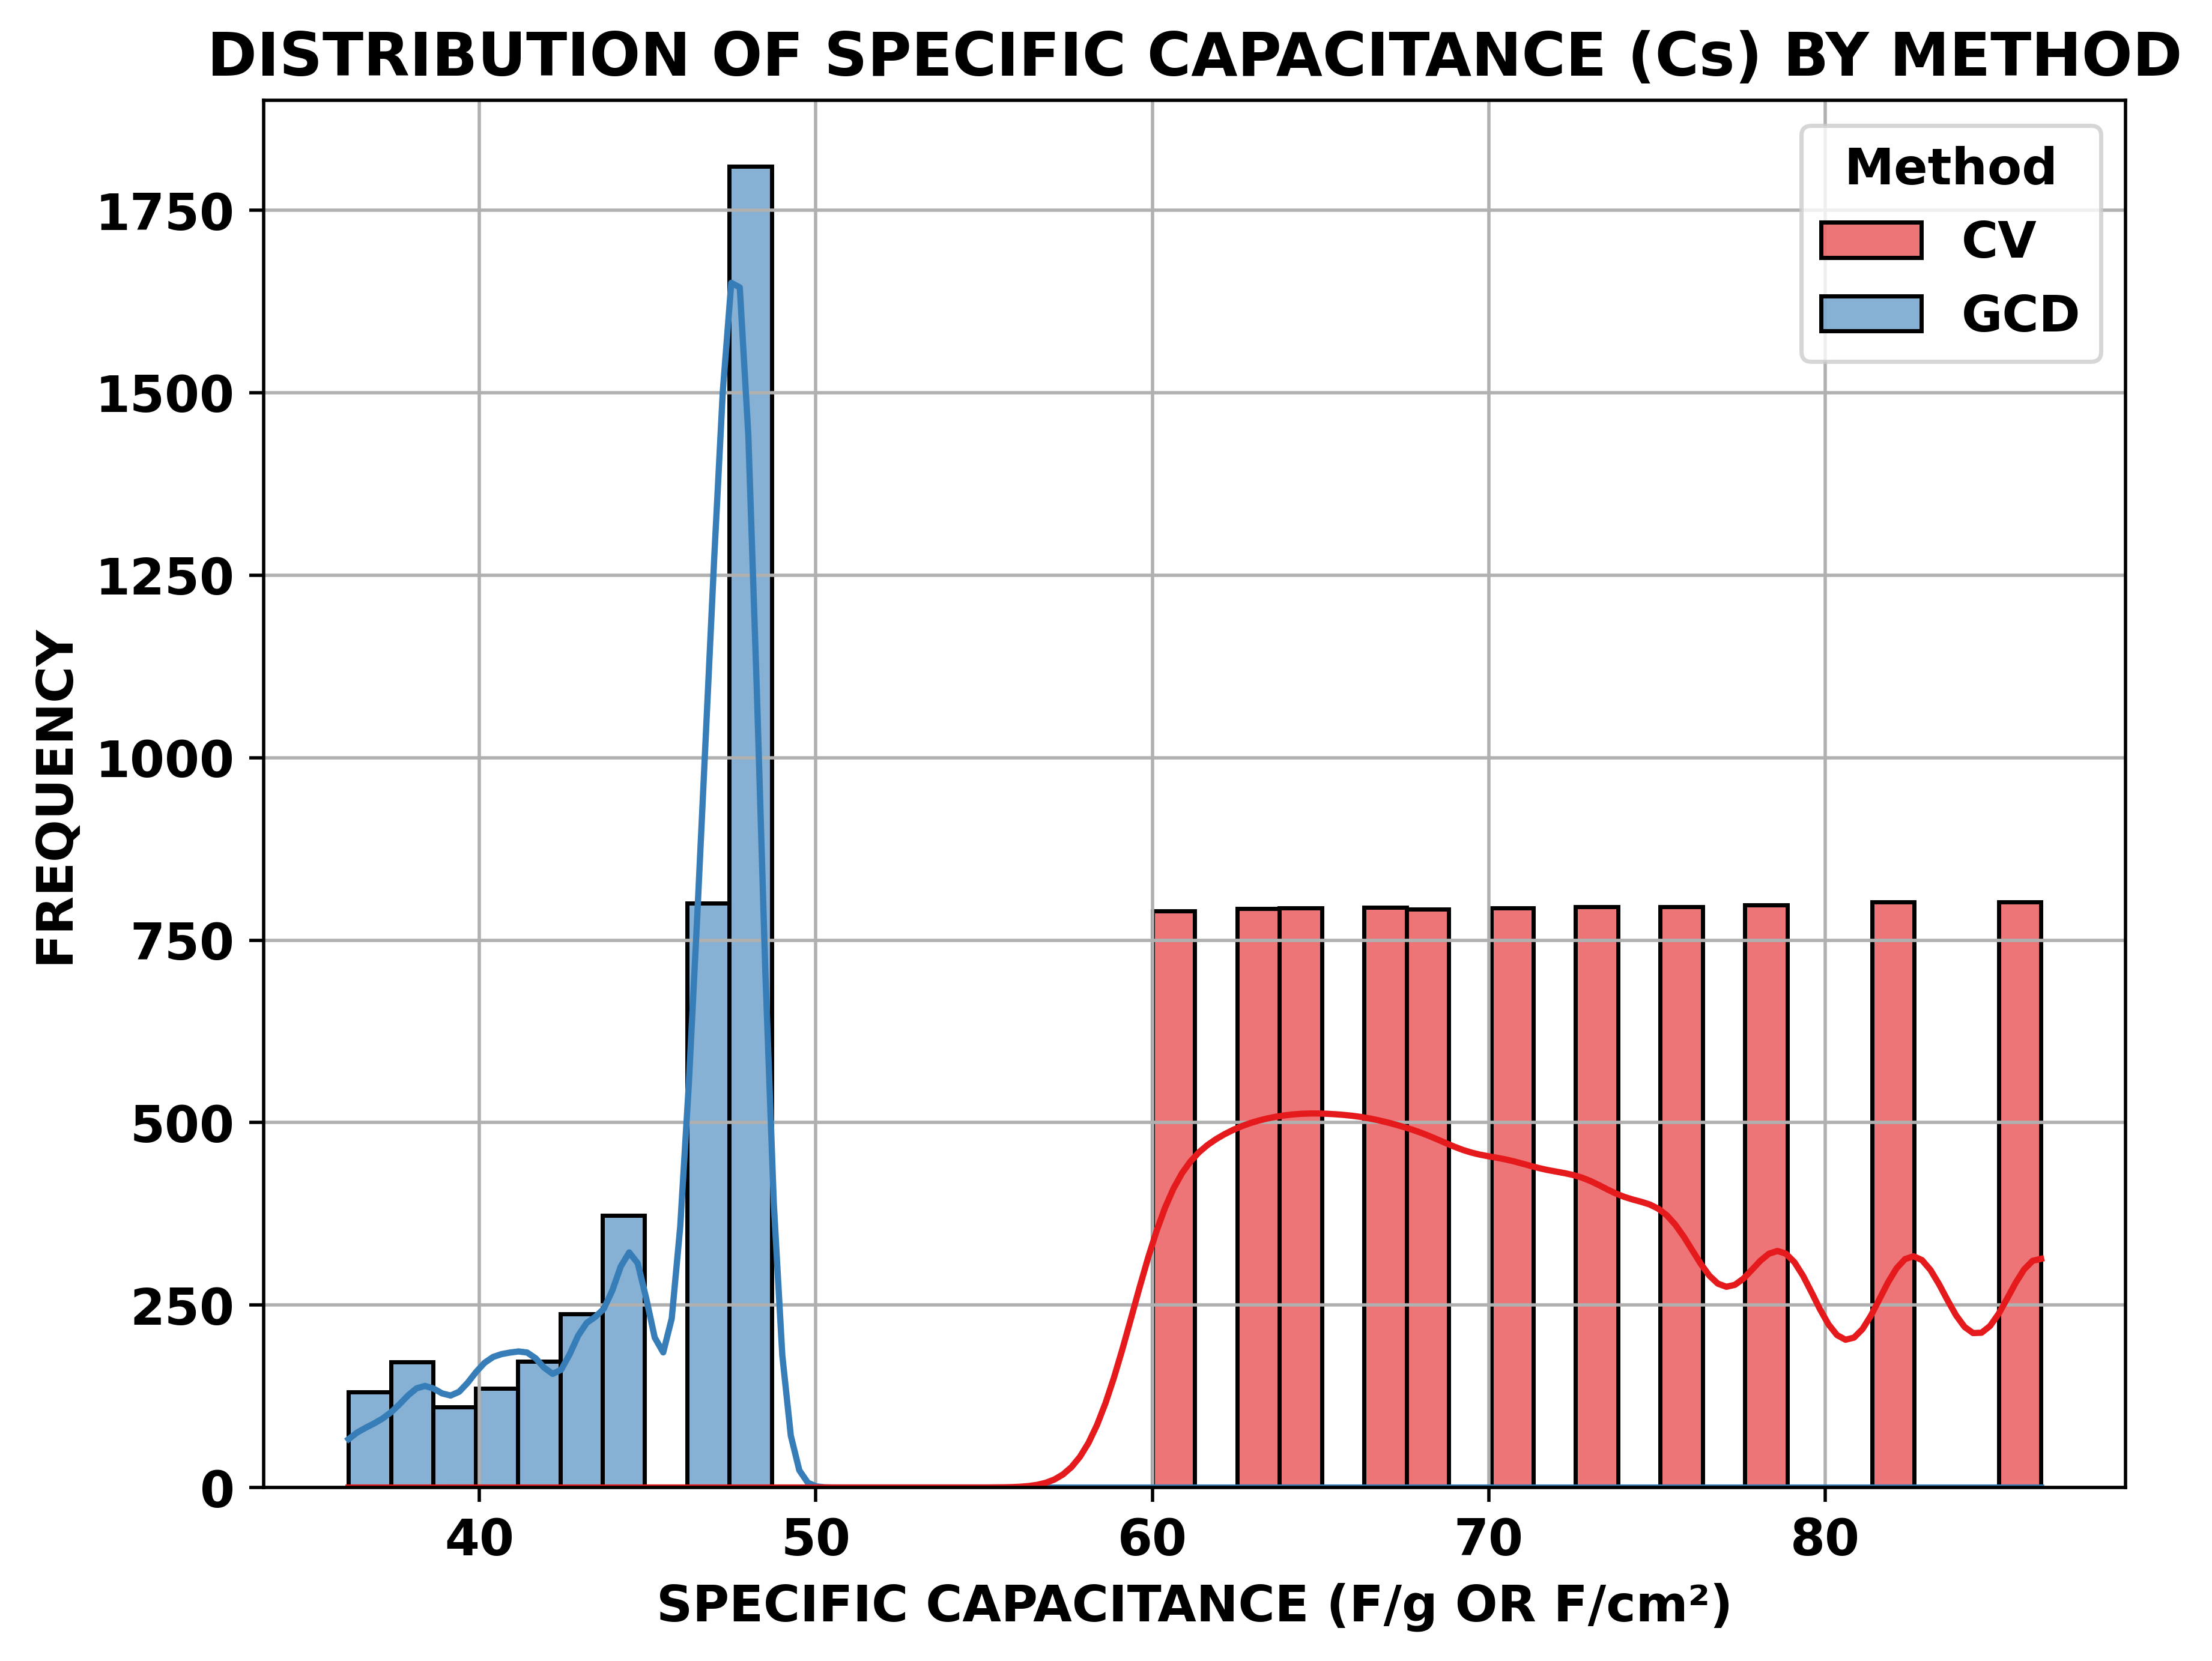

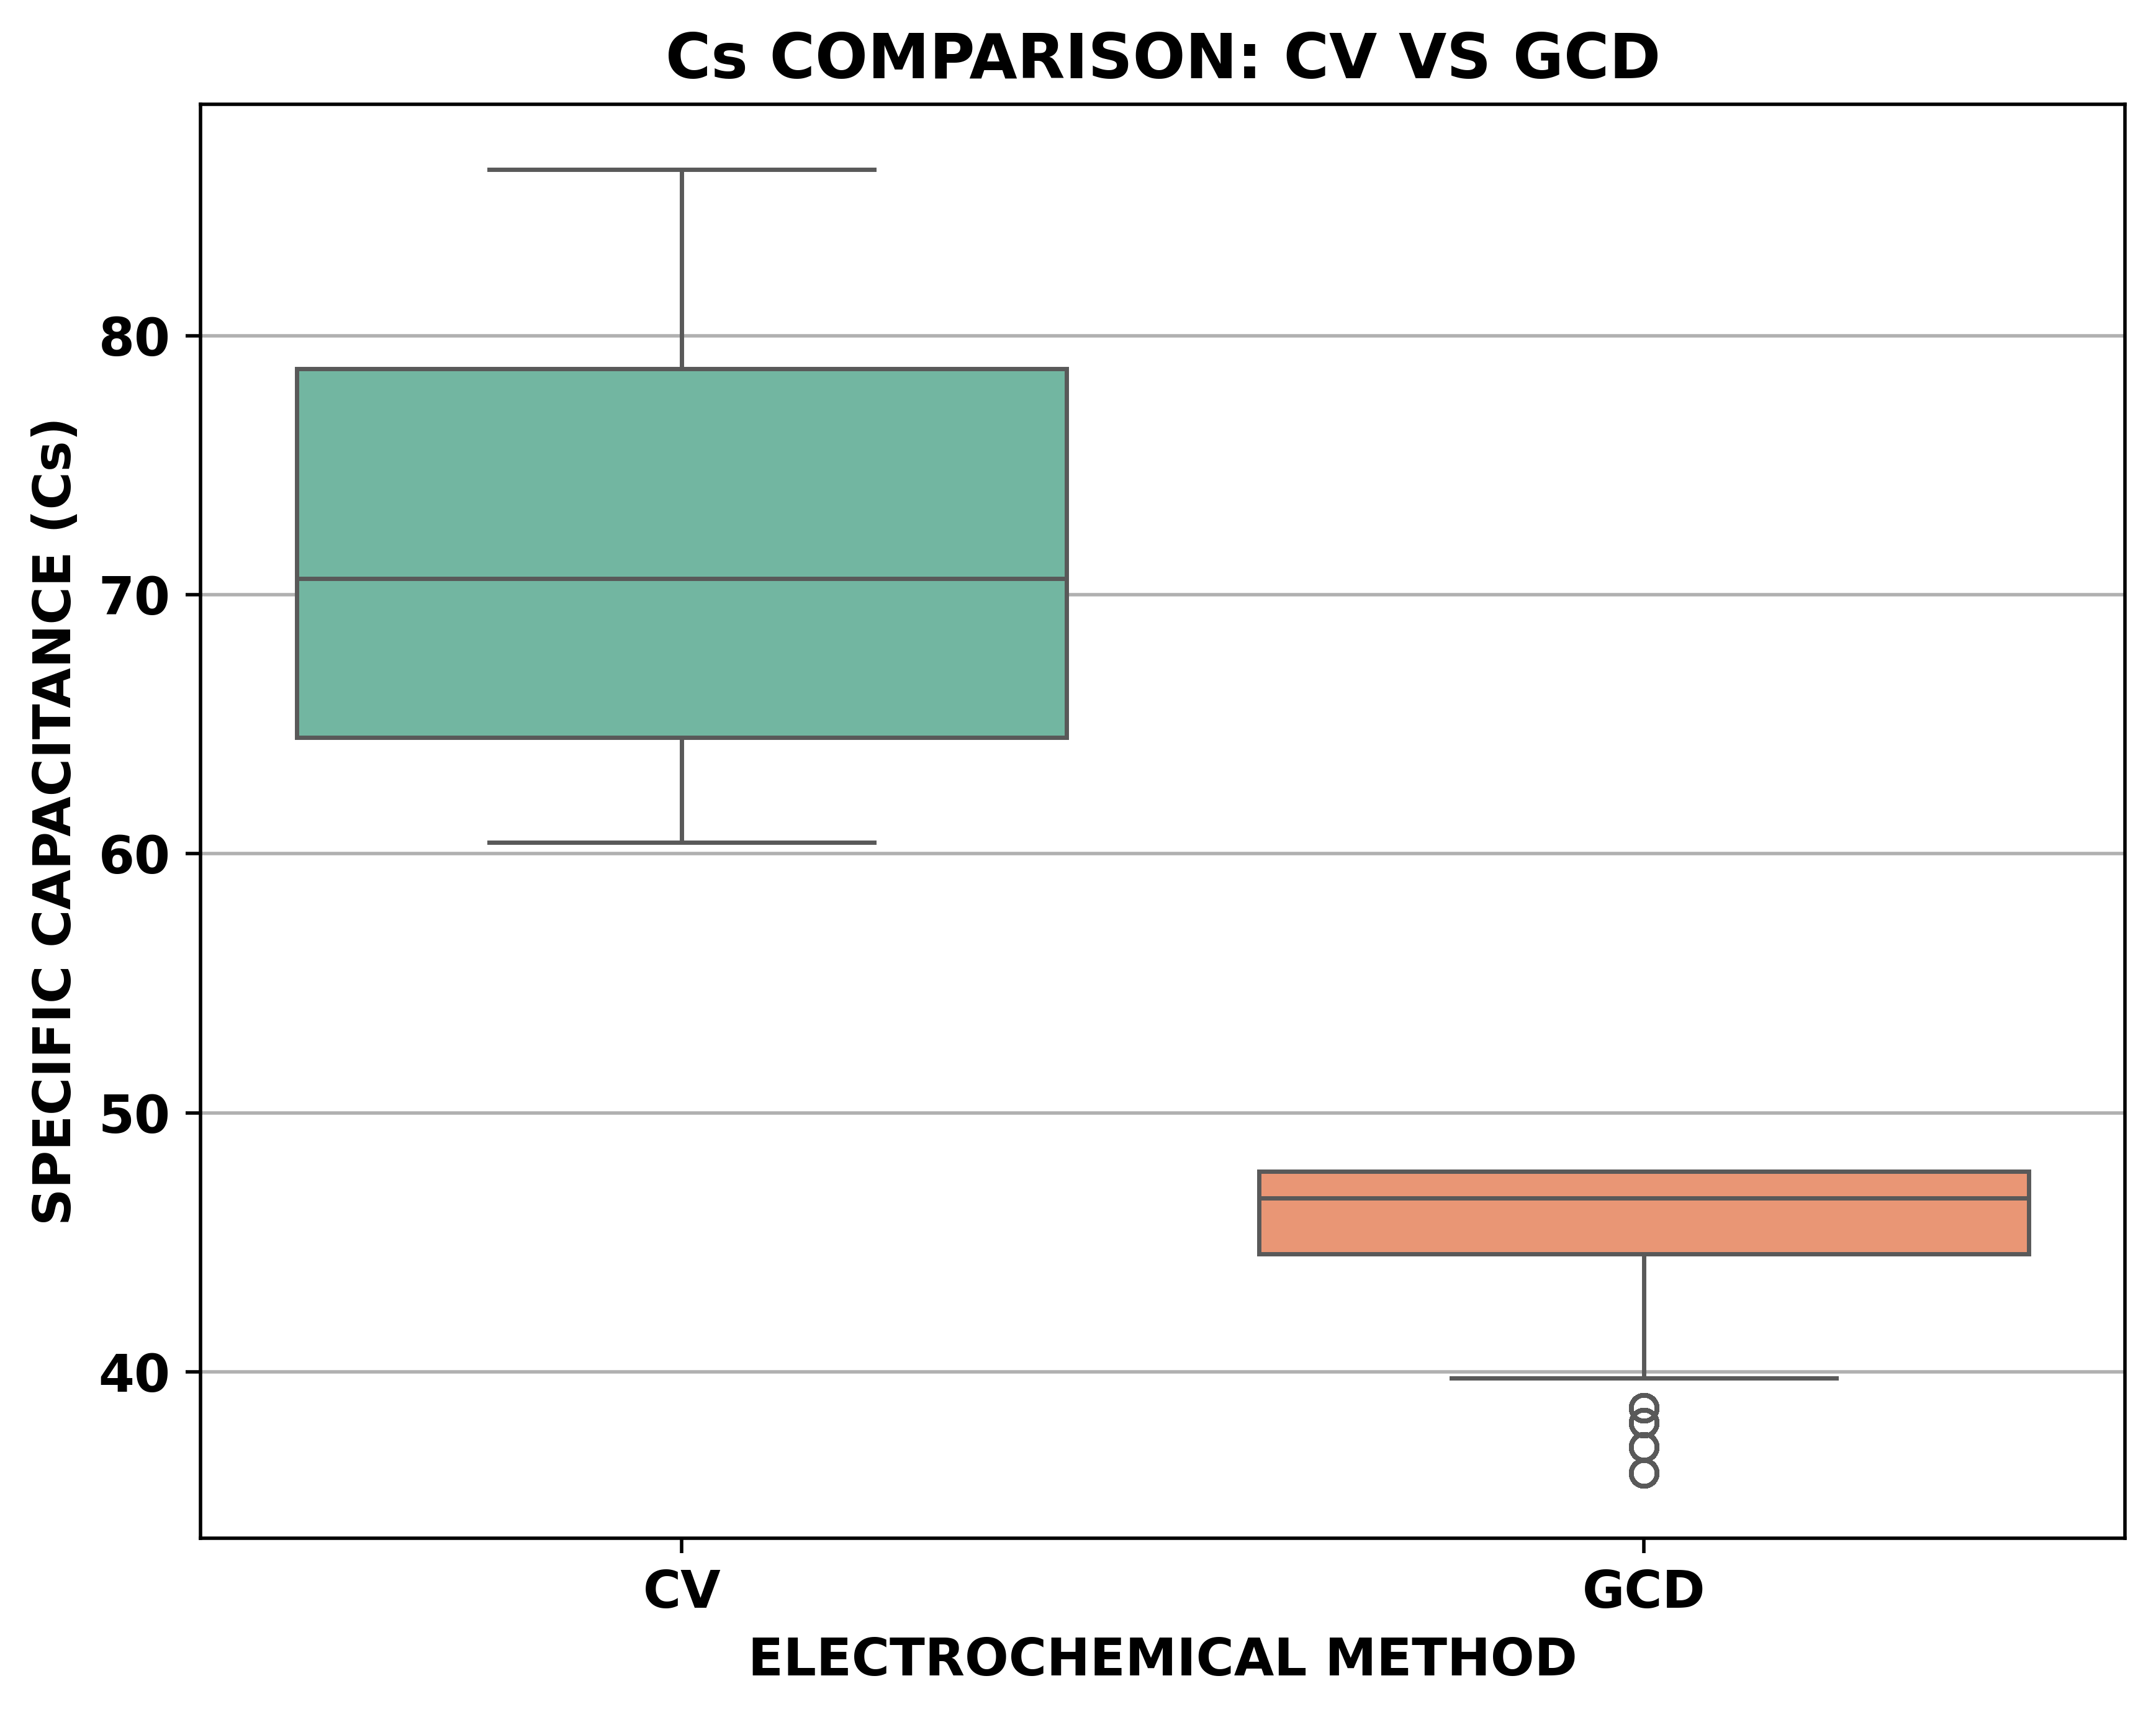

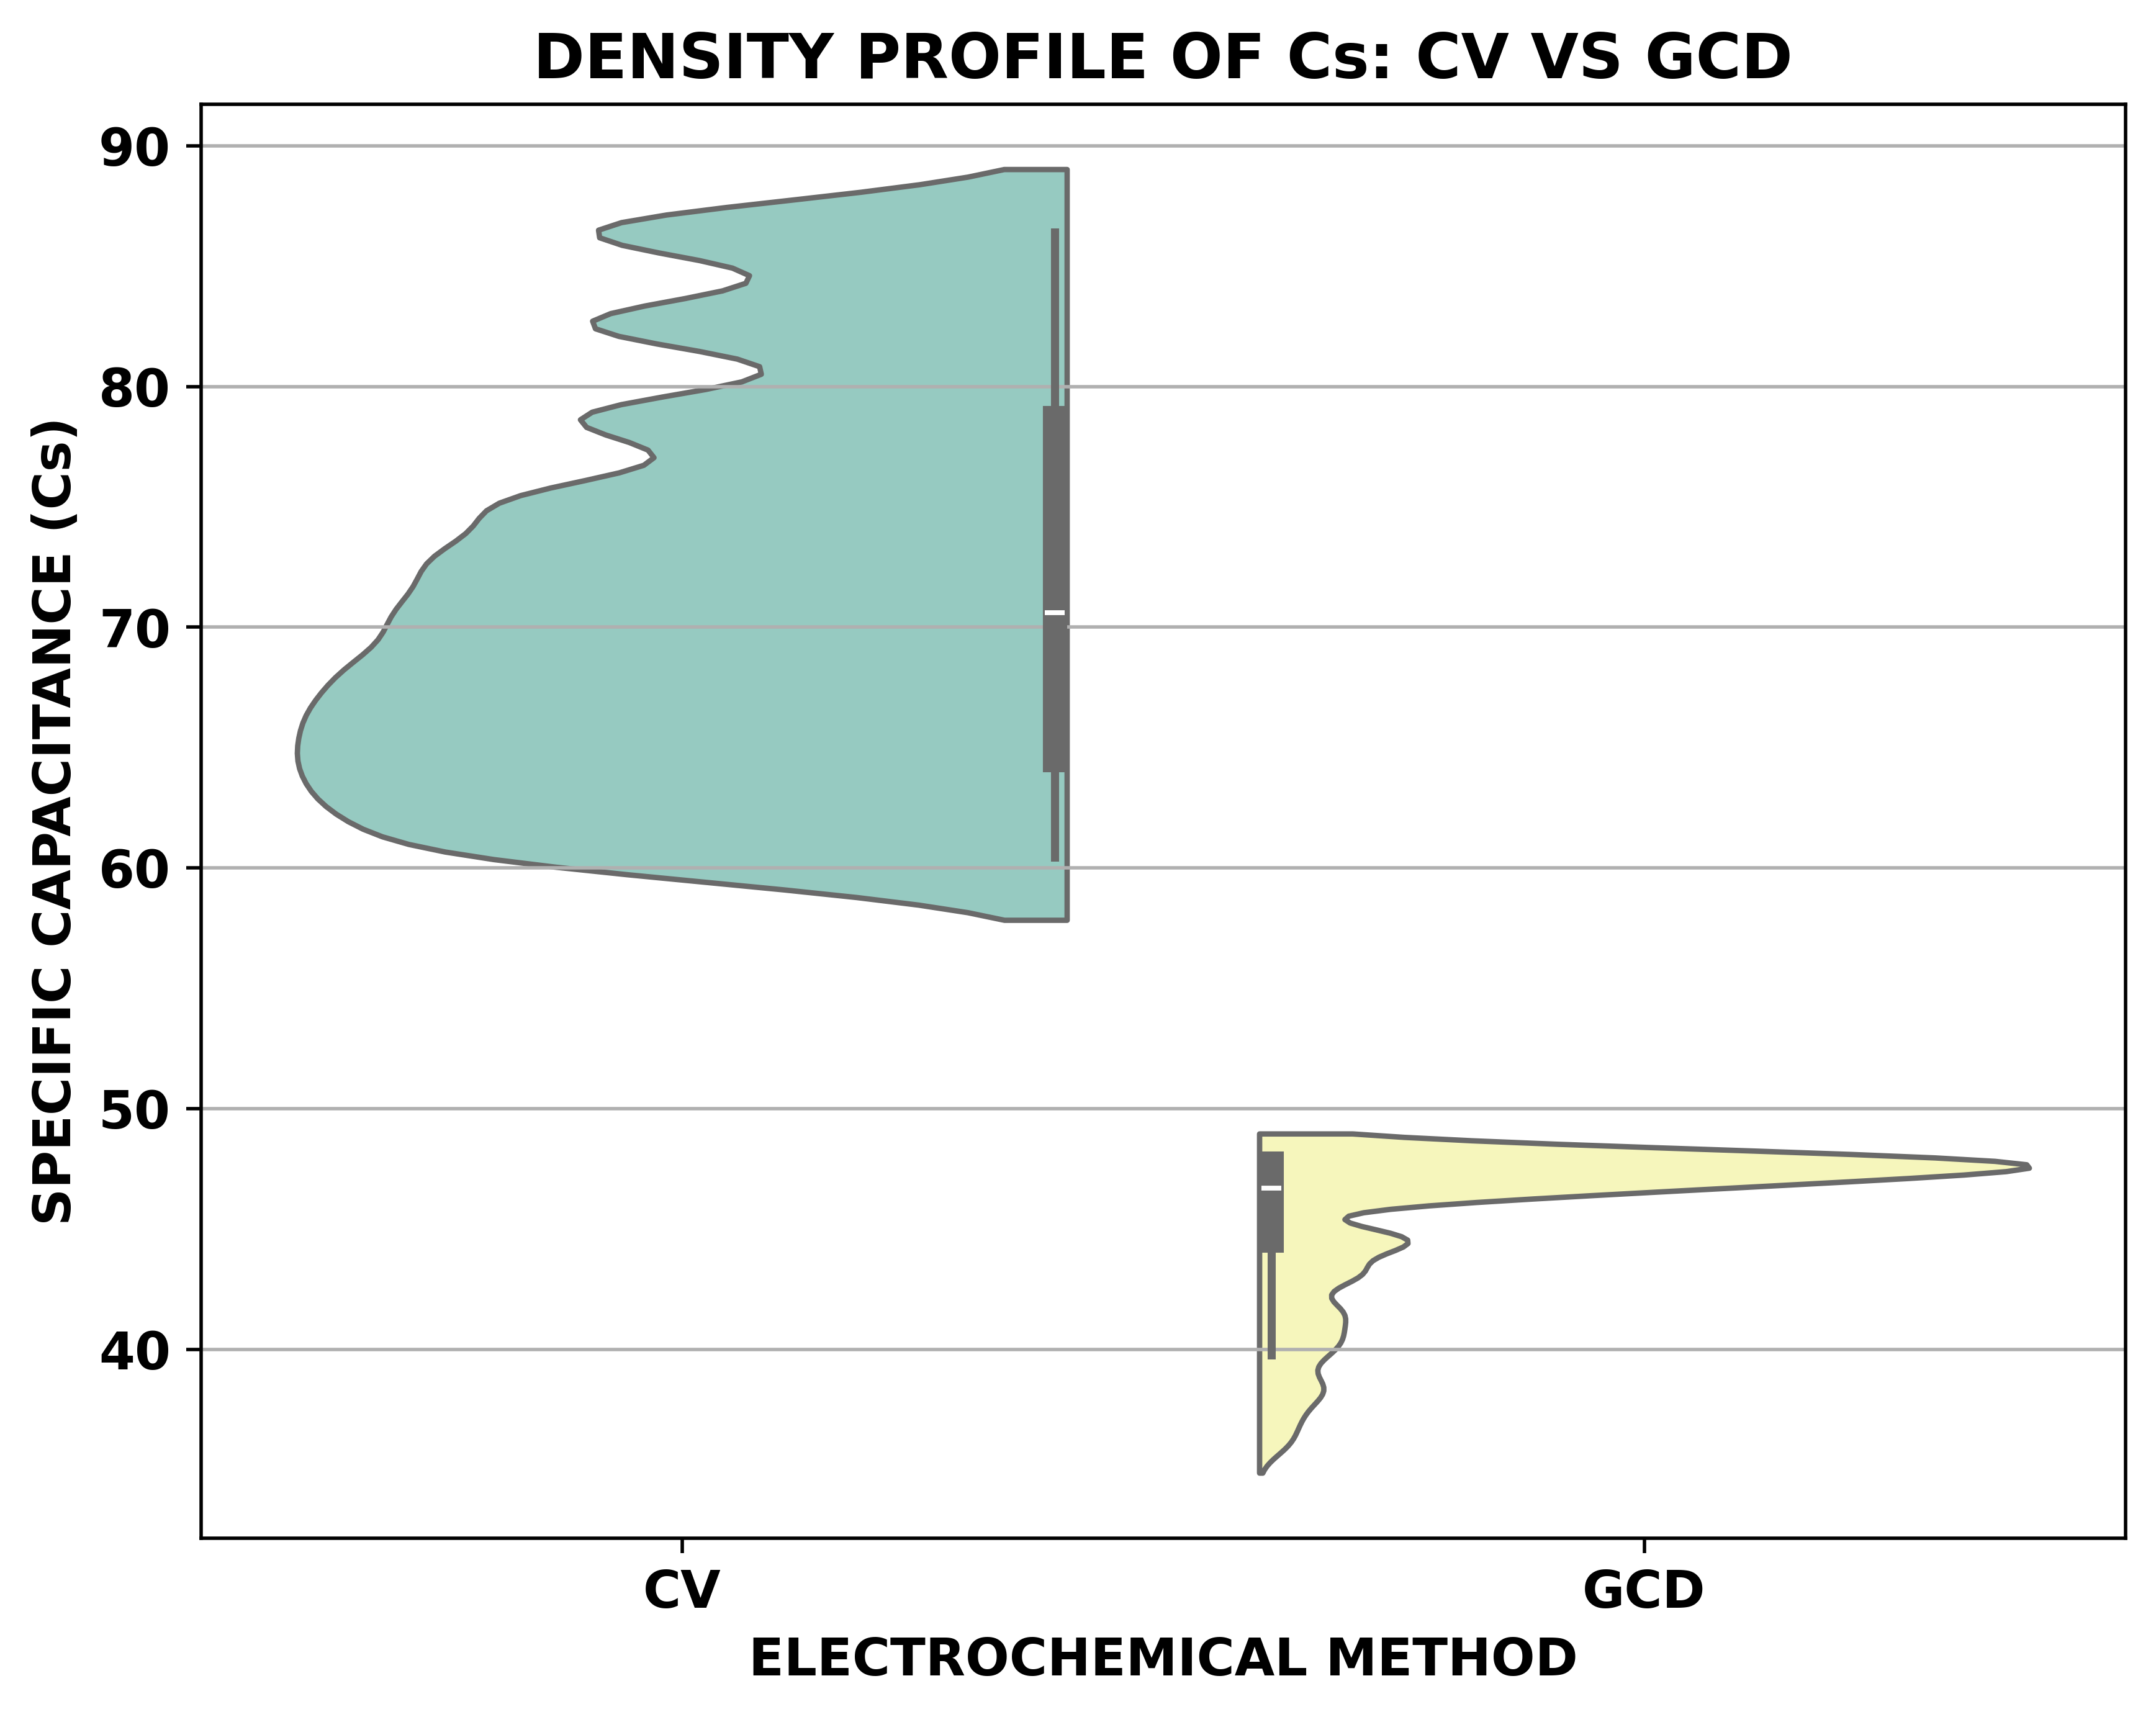

In [42]:
def plot_cs_distributions(unified_df: pd.DataFrame):
    """
    PLOTS HISTOGRAMS, KDE, AND BOXPLOTS FOR SPECIFIC CAPACITANCE (Cs).
    COMPARES CV VS GCD METHODOLOGIES.
    """
    # 1. HISTOGRAM WITH KDE
    plt.figure()
    sns.histplot(data=unified_df, x='Cs', hue='Method', kde=True, palette='Set1', bins=40, alpha=0.6)
    plt.title('DISTRIBUTION OF SPECIFIC CAPACITANCE (Cs) BY METHOD')
    plt.xlabel('SPECIFIC CAPACITANCE (F/g OR F/cm²)')
    plt.ylabel('FREQUENCY')
    plt.show()

    # 2. BOXPLOT FOR OUTLIERS AND MEDIAN SPREAD
    plt.figure()
    sns.boxplot(data=unified_df, x='Method', y='Cs', palette='Set2')
    plt.title('Cs COMPARISON: CV VS GCD')
    plt.xlabel('ELECTROCHEMICAL METHOD')
    plt.ylabel('SPECIFIC CAPACITANCE (Cs)')
    plt.show()
    
    # 3. VIOLIN PLOT FOR DENSITY BEHAVIOR
    plt.figure()
    sns.violinplot(data=unified_df, x='Method', y='Cs', palette='Set3', split=True)
    plt.title('DENSITY PROFILE OF Cs: CV VS GCD')
    plt.xlabel('ELECTROCHEMICAL METHOD')
    plt.ylabel('SPECIFIC CAPACITANCE (Cs)')
    plt.show()

plot_cs_distributions(unified_df)

### 4.2 ELECTROCHEMICAL VISUALIZATIONS (CV-SPECIFIC)

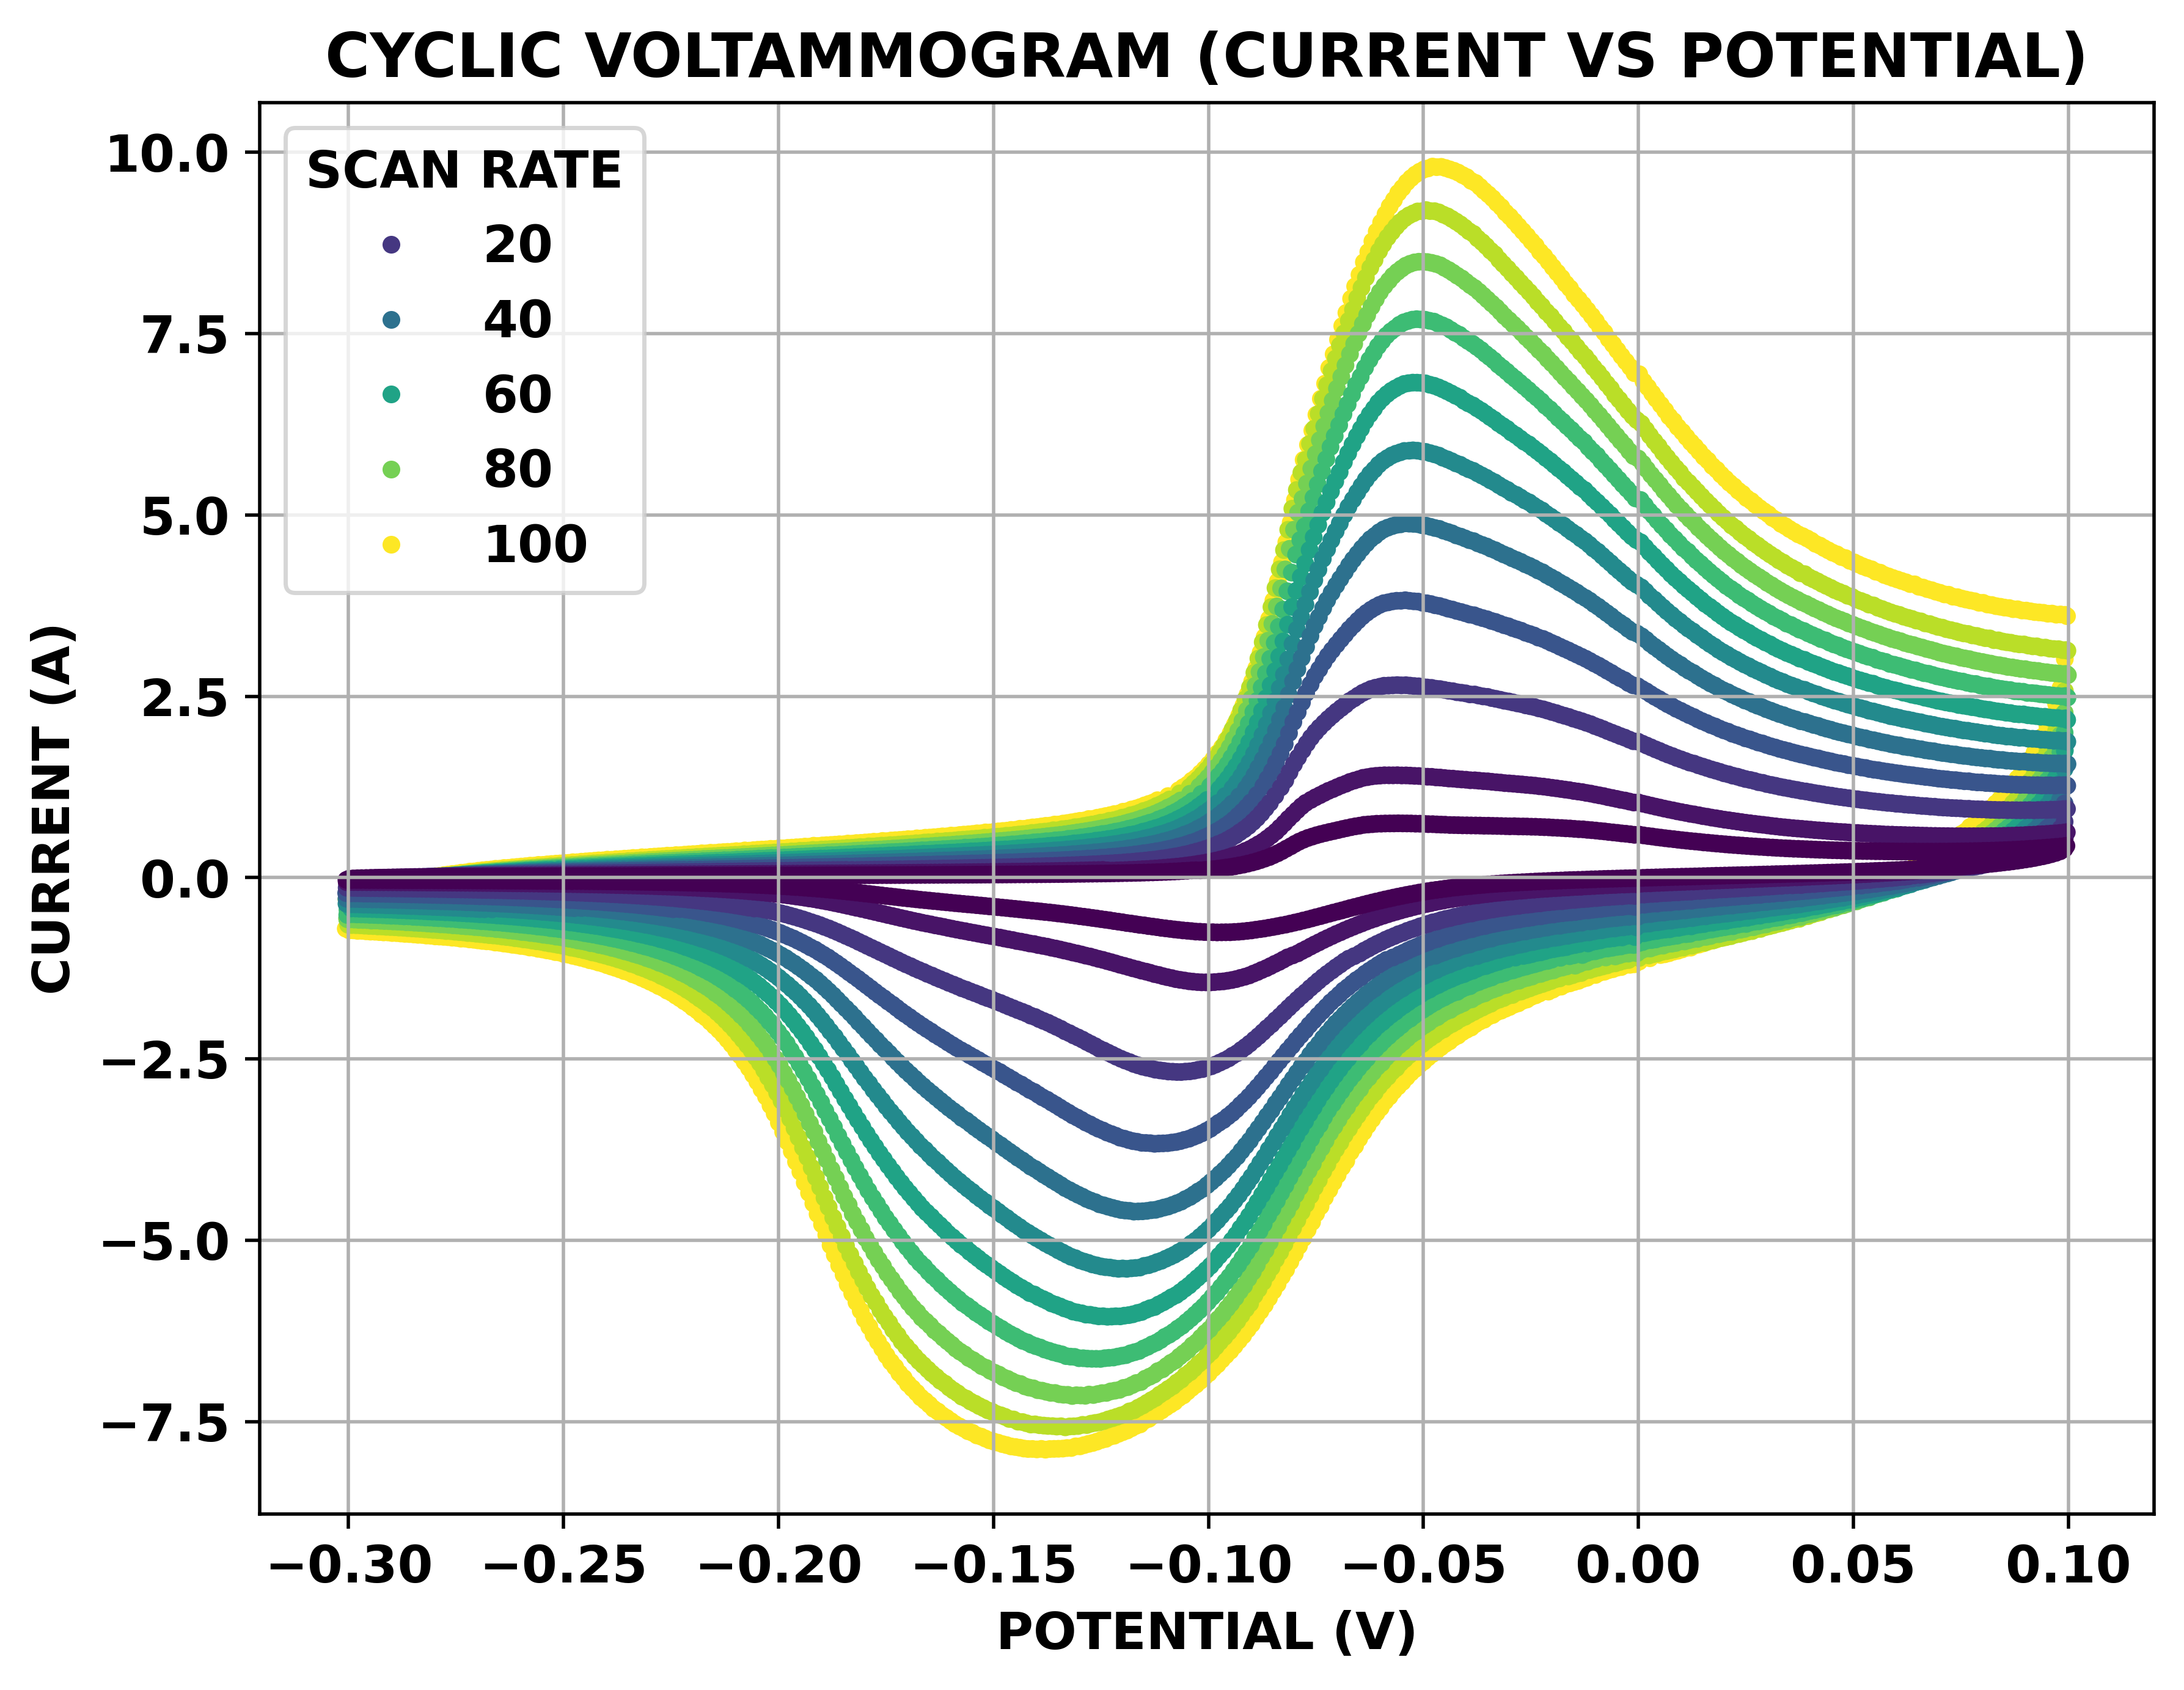

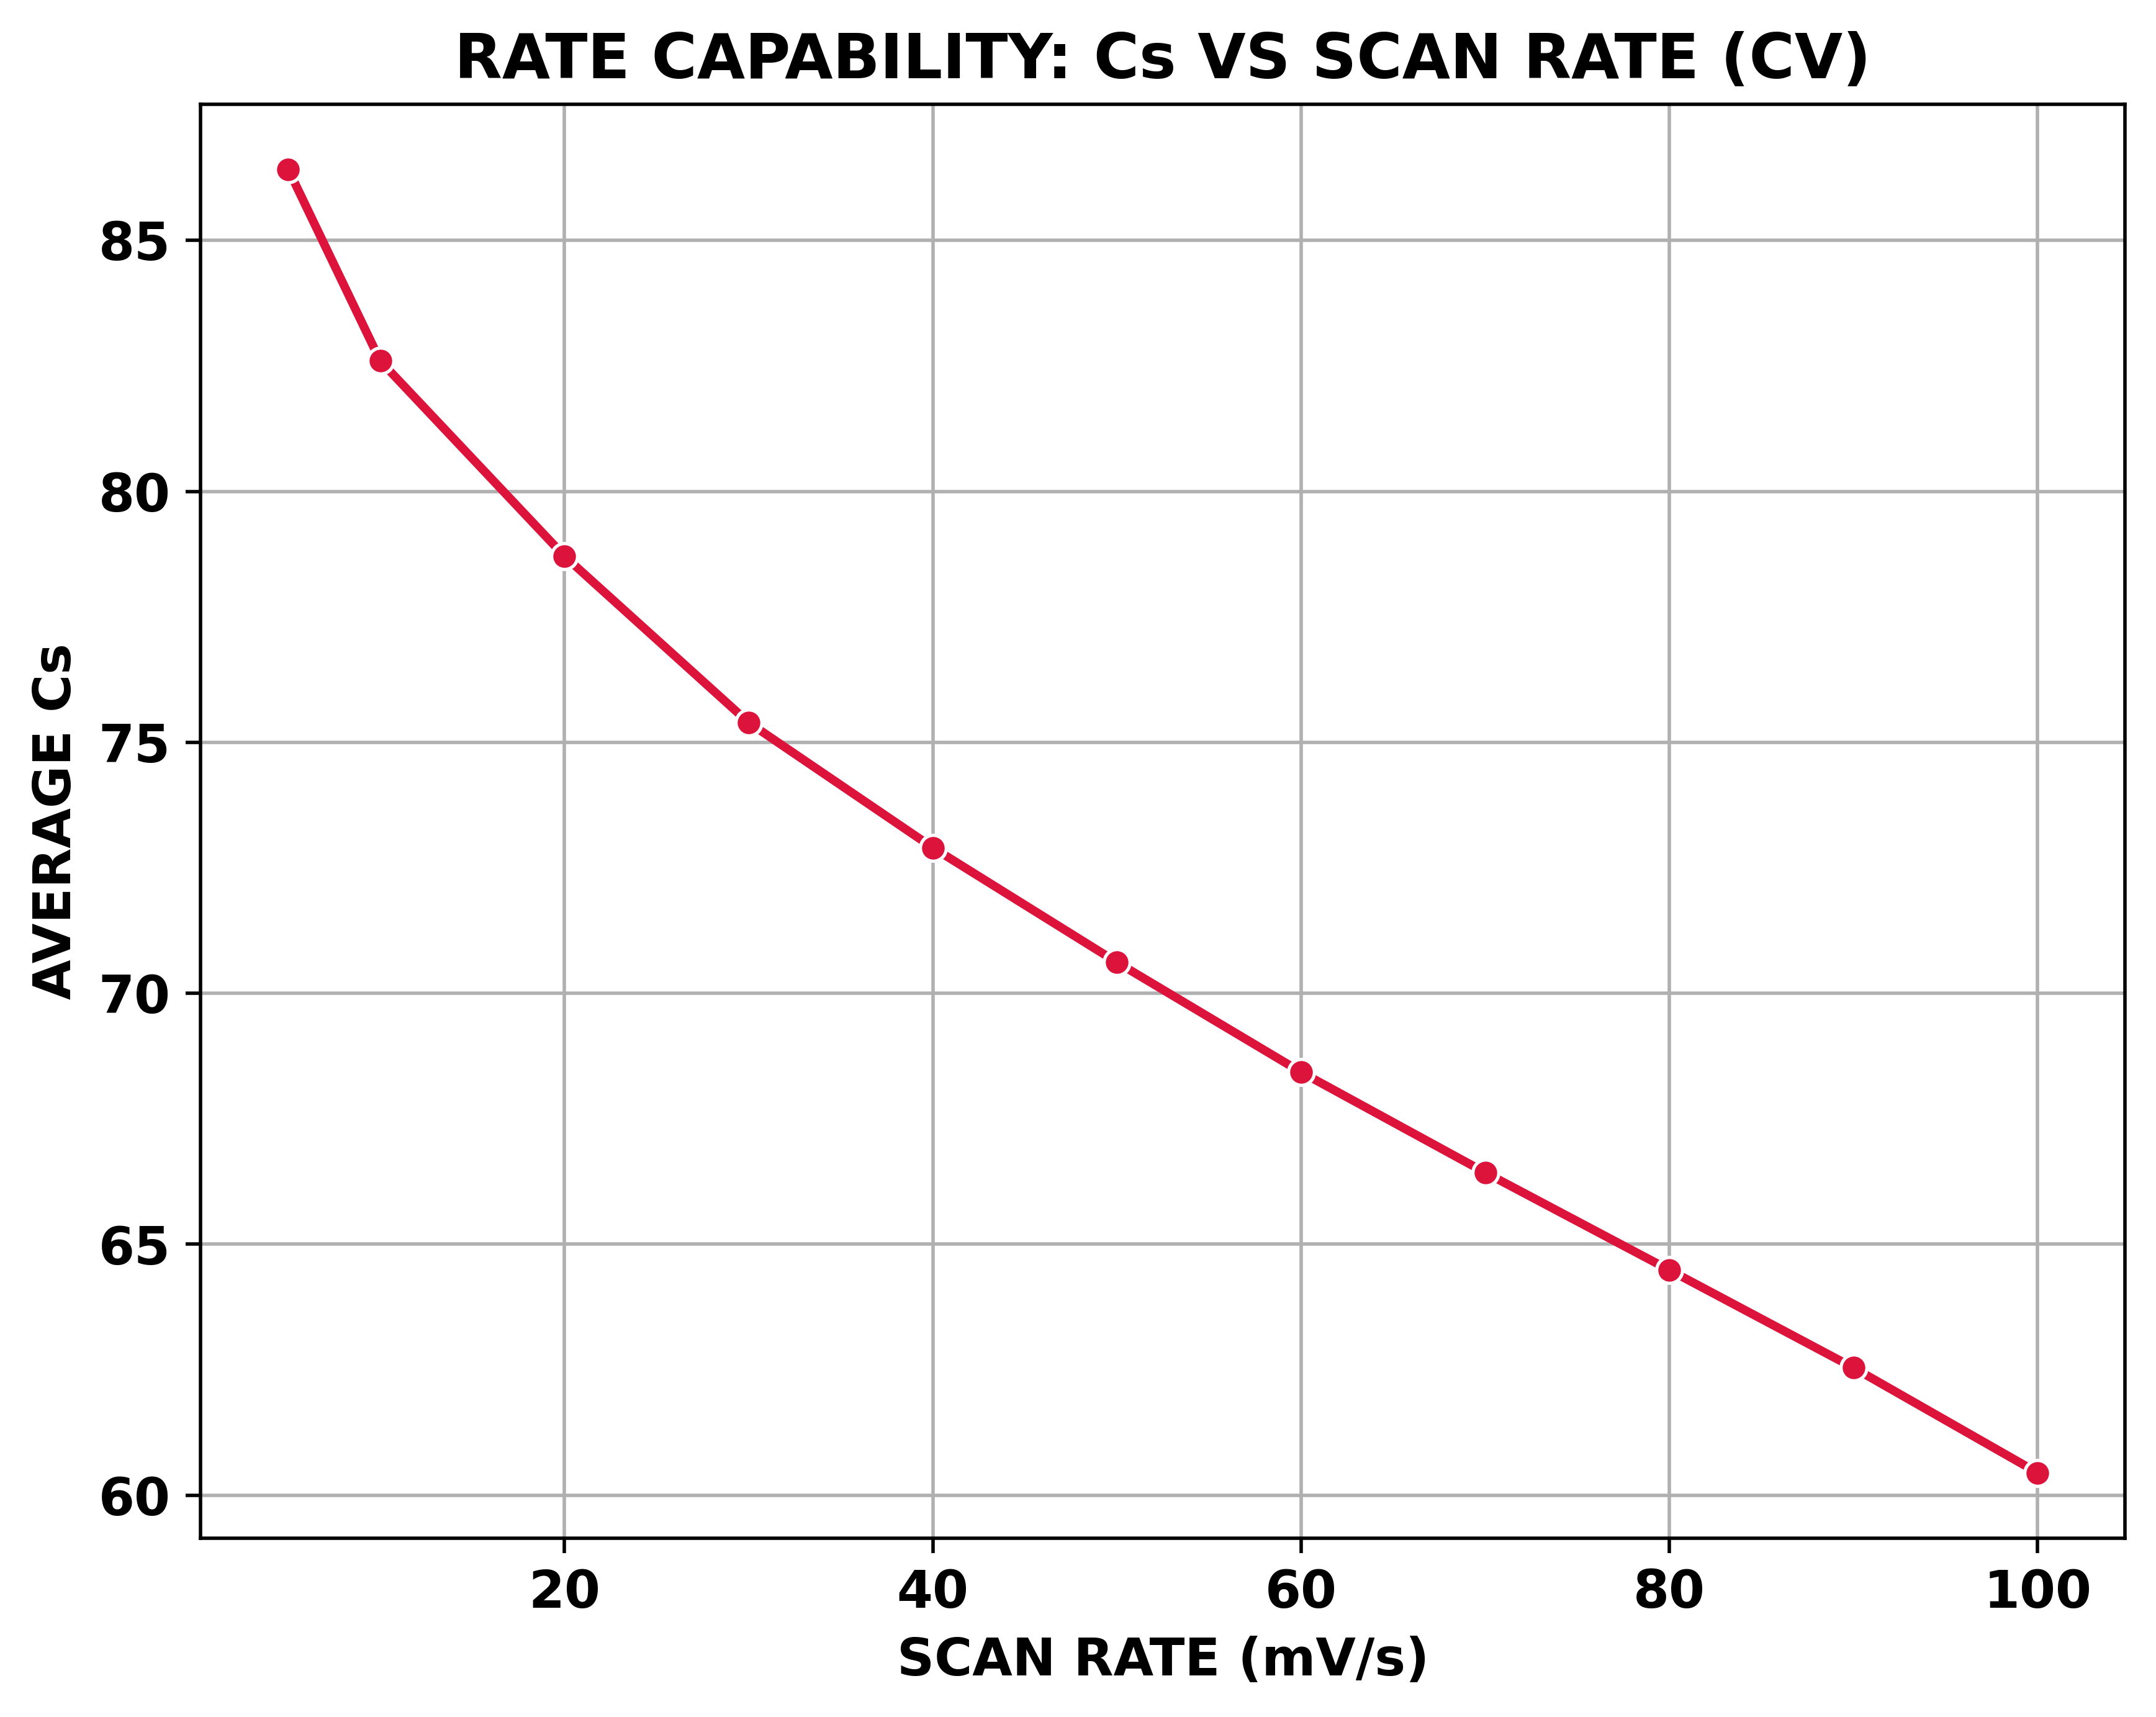

In [43]:
def plot_cv_electrochemistry(cv_df: pd.DataFrame):
    """
    PLOTS CURRENT VS POTENTIAL (CYCLIC VOLTAMMOGRAMS) AND Cs VS SCAN RATE.
    """
    # 1. CYCLIC VOLTAMMOGRAMS AT VARIOUS SCAN RATES
    plt.figure()
    sns.scatterplot(data=cv_df, x='Potential', y='Current', hue='Scan_Rate', palette='viridis', edgecolor=None, s=15)
    plt.title('CYCLIC VOLTAMMOGRAM (CURRENT VS POTENTIAL)')
    plt.xlabel('POTENTIAL (V)')
    plt.ylabel('CURRENT (A)')
    plt.legend(title='SCAN RATE')
    plt.show()

    # 2. Cs VS SCAN RATE (RATE PERFORMANCE)
    cv_rate = cv_df.groupby('Scan_Rate')['Cs'].mean().reset_index()
    plt.figure()
    sns.lineplot(data=cv_rate, x='Scan_Rate', y='Cs', marker='o', color='crimson', linewidth=2)
    plt.title('RATE CAPABILITY: Cs VS SCAN RATE (CV)')
    plt.xlabel('SCAN RATE (mV/s)')
    plt.ylabel('AVERAGE Cs')
    plt.show()

plot_cv_electrochemistry(cv_clean)

### 4.3 ELECTROCHEMICAL VISUALIZATIONS (GCD-SPECIFIC)

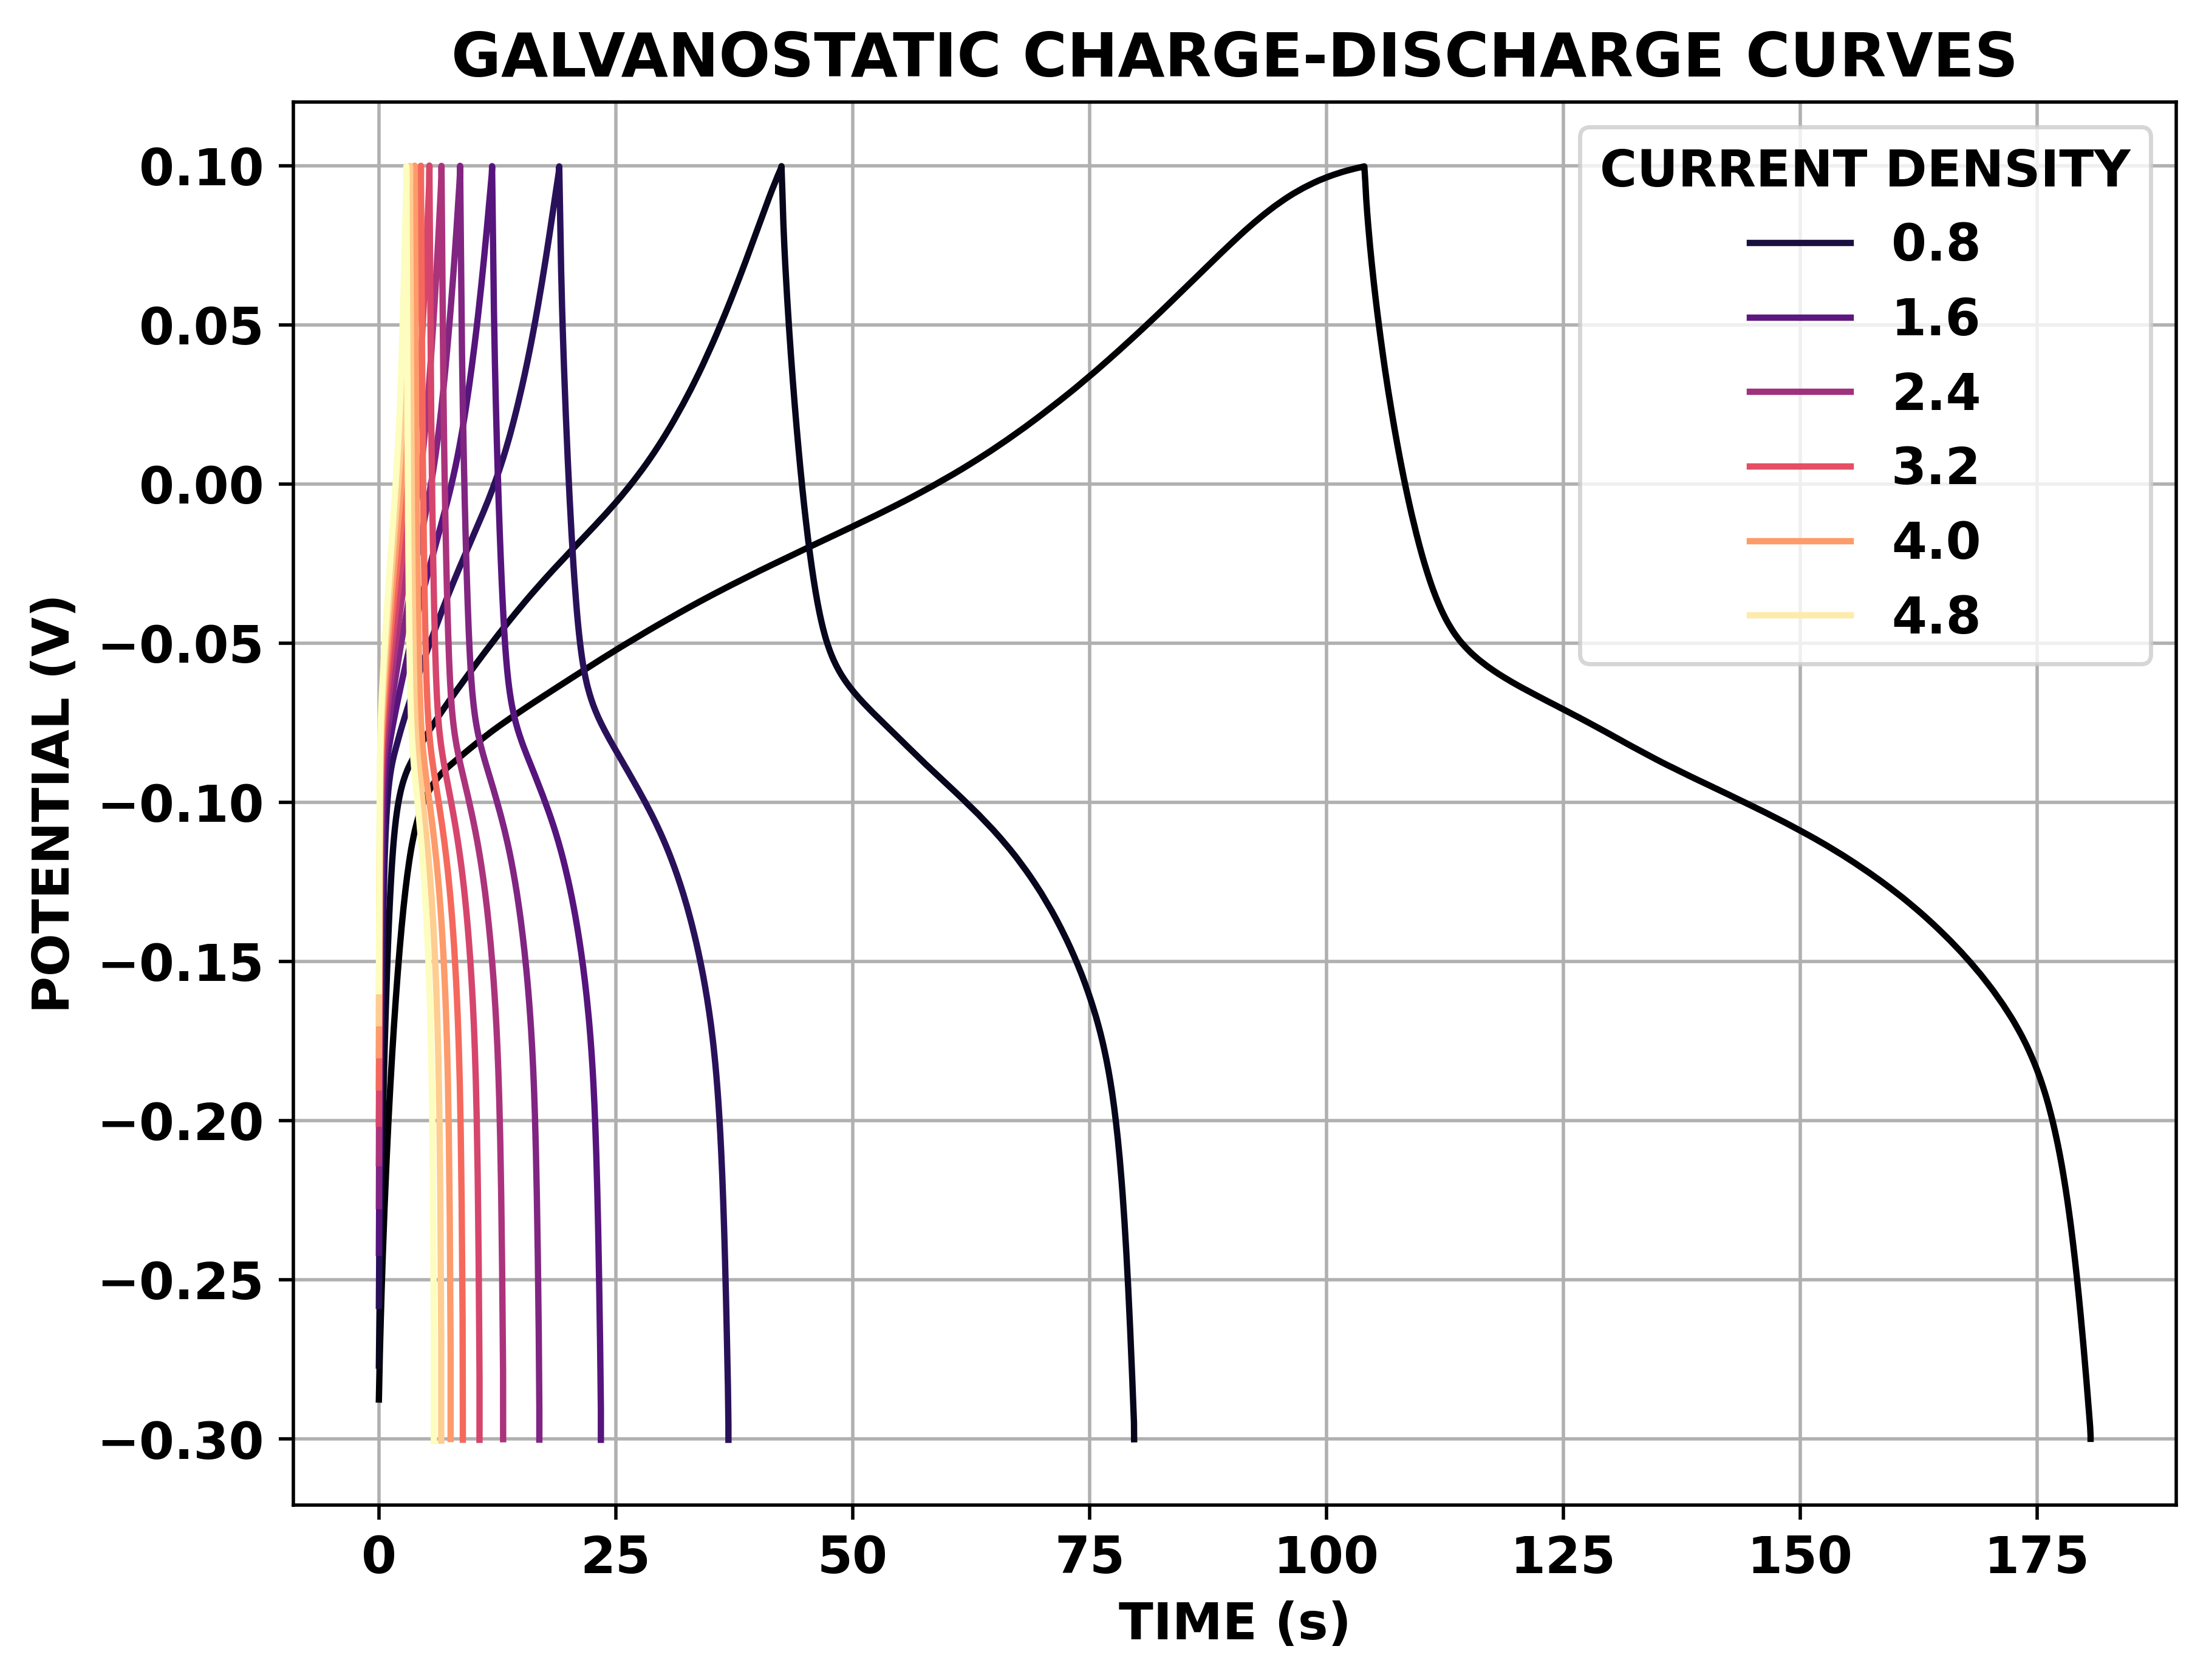

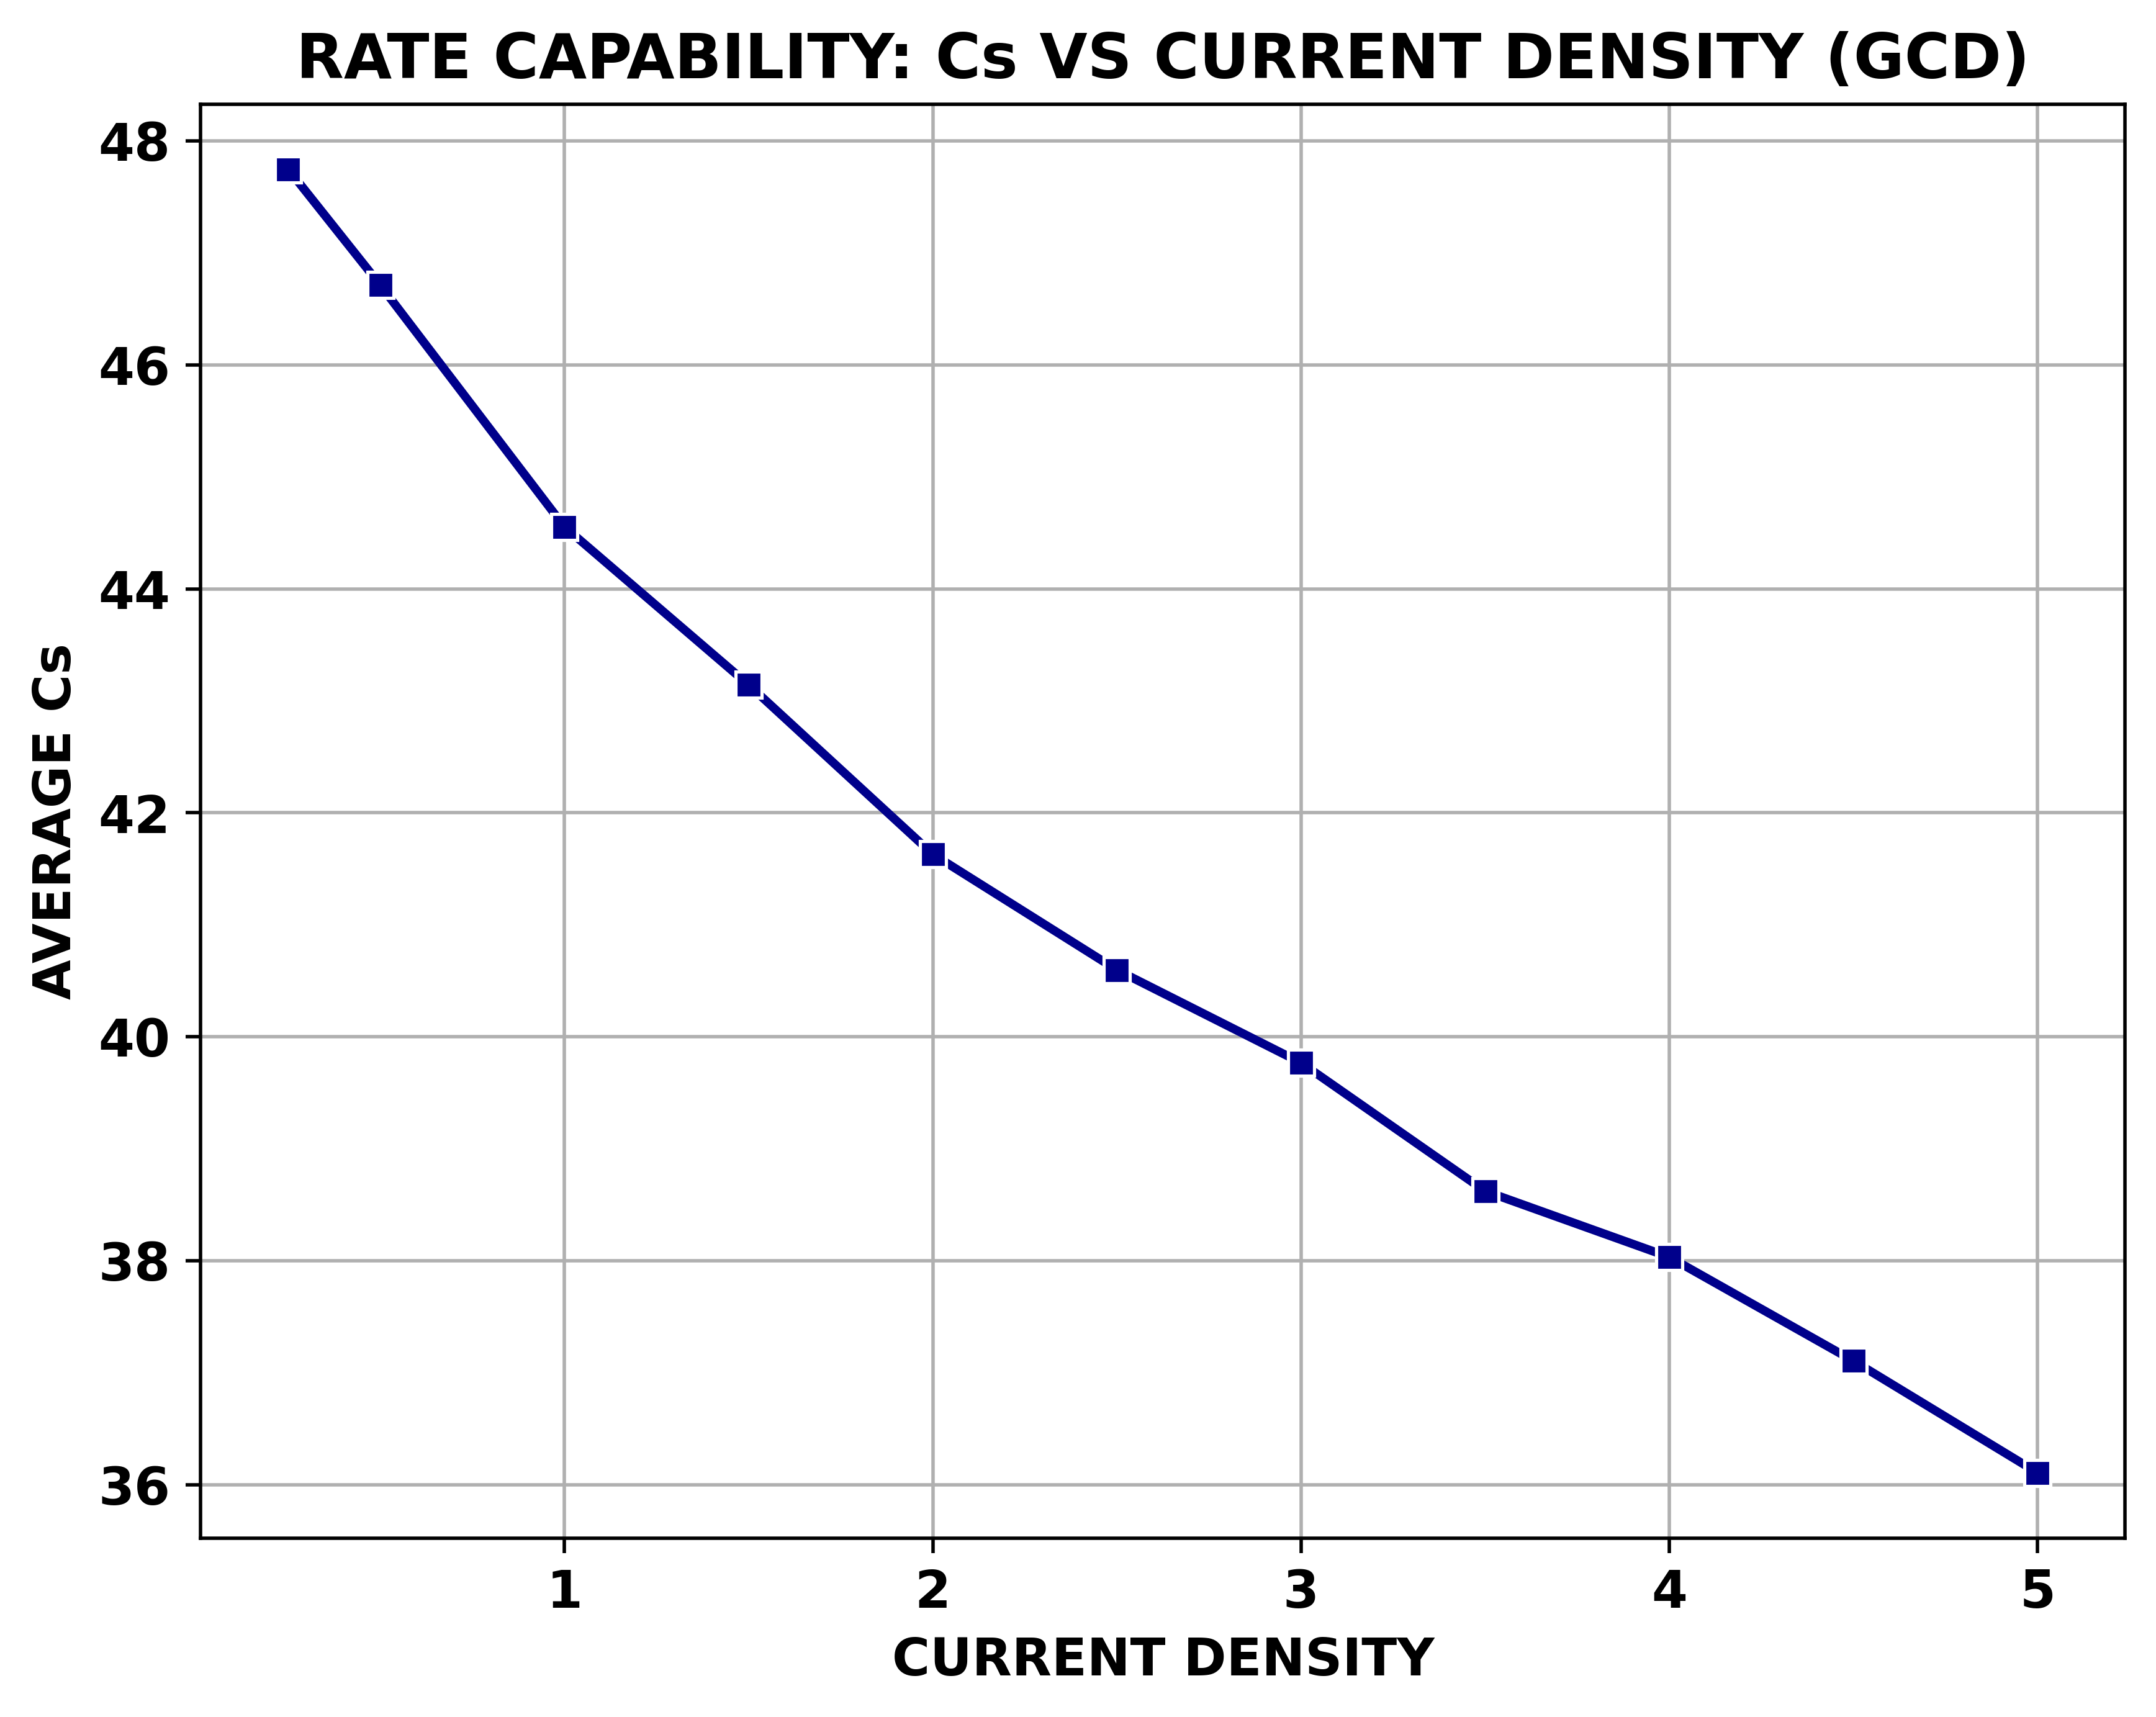

In [44]:
def plot_gcd_electrochemistry(gcd_df: pd.DataFrame):
    """
    PLOTS VOLTAGE VS TIME (CHARGE-DISCHARGE CURVES) AND Cs VS CURRENT DENSITY.
    """
    # 1. GCD CURVES (VOLTAGE VS TIME)
    plt.figure()
    sns.lineplot(data=gcd_df, x='Time', y='Potential', hue='Current_Density', palette='magma')
    plt.title('GALVANOSTATIC CHARGE-DISCHARGE CURVES')
    plt.xlabel('TIME (s)')
    plt.ylabel('POTENTIAL (V)')
    plt.legend(title='CURRENT DENSITY')
    plt.show()

    # 2. Cs VS CURRENT DENSITY (RATE PERFORMANCE)
    gcd_rate = gcd_df.groupby('Current_Density')['Cs'].mean().reset_index()
    plt.figure()
    sns.lineplot(data=gcd_rate, x='Current_Density', y='Cs', marker='s', color='darkblue', linewidth=2)
    plt.title('RATE CAPABILITY: Cs VS CURRENT DENSITY (GCD)')
    plt.xlabel('CURRENT DENSITY')
    plt.ylabel('AVERAGE Cs')
    plt.show()

plot_gcd_electrochemistry(gcd_clean)

### 4.4 STATISTICAL FEATURE ANALYSIS AND CORRELATION

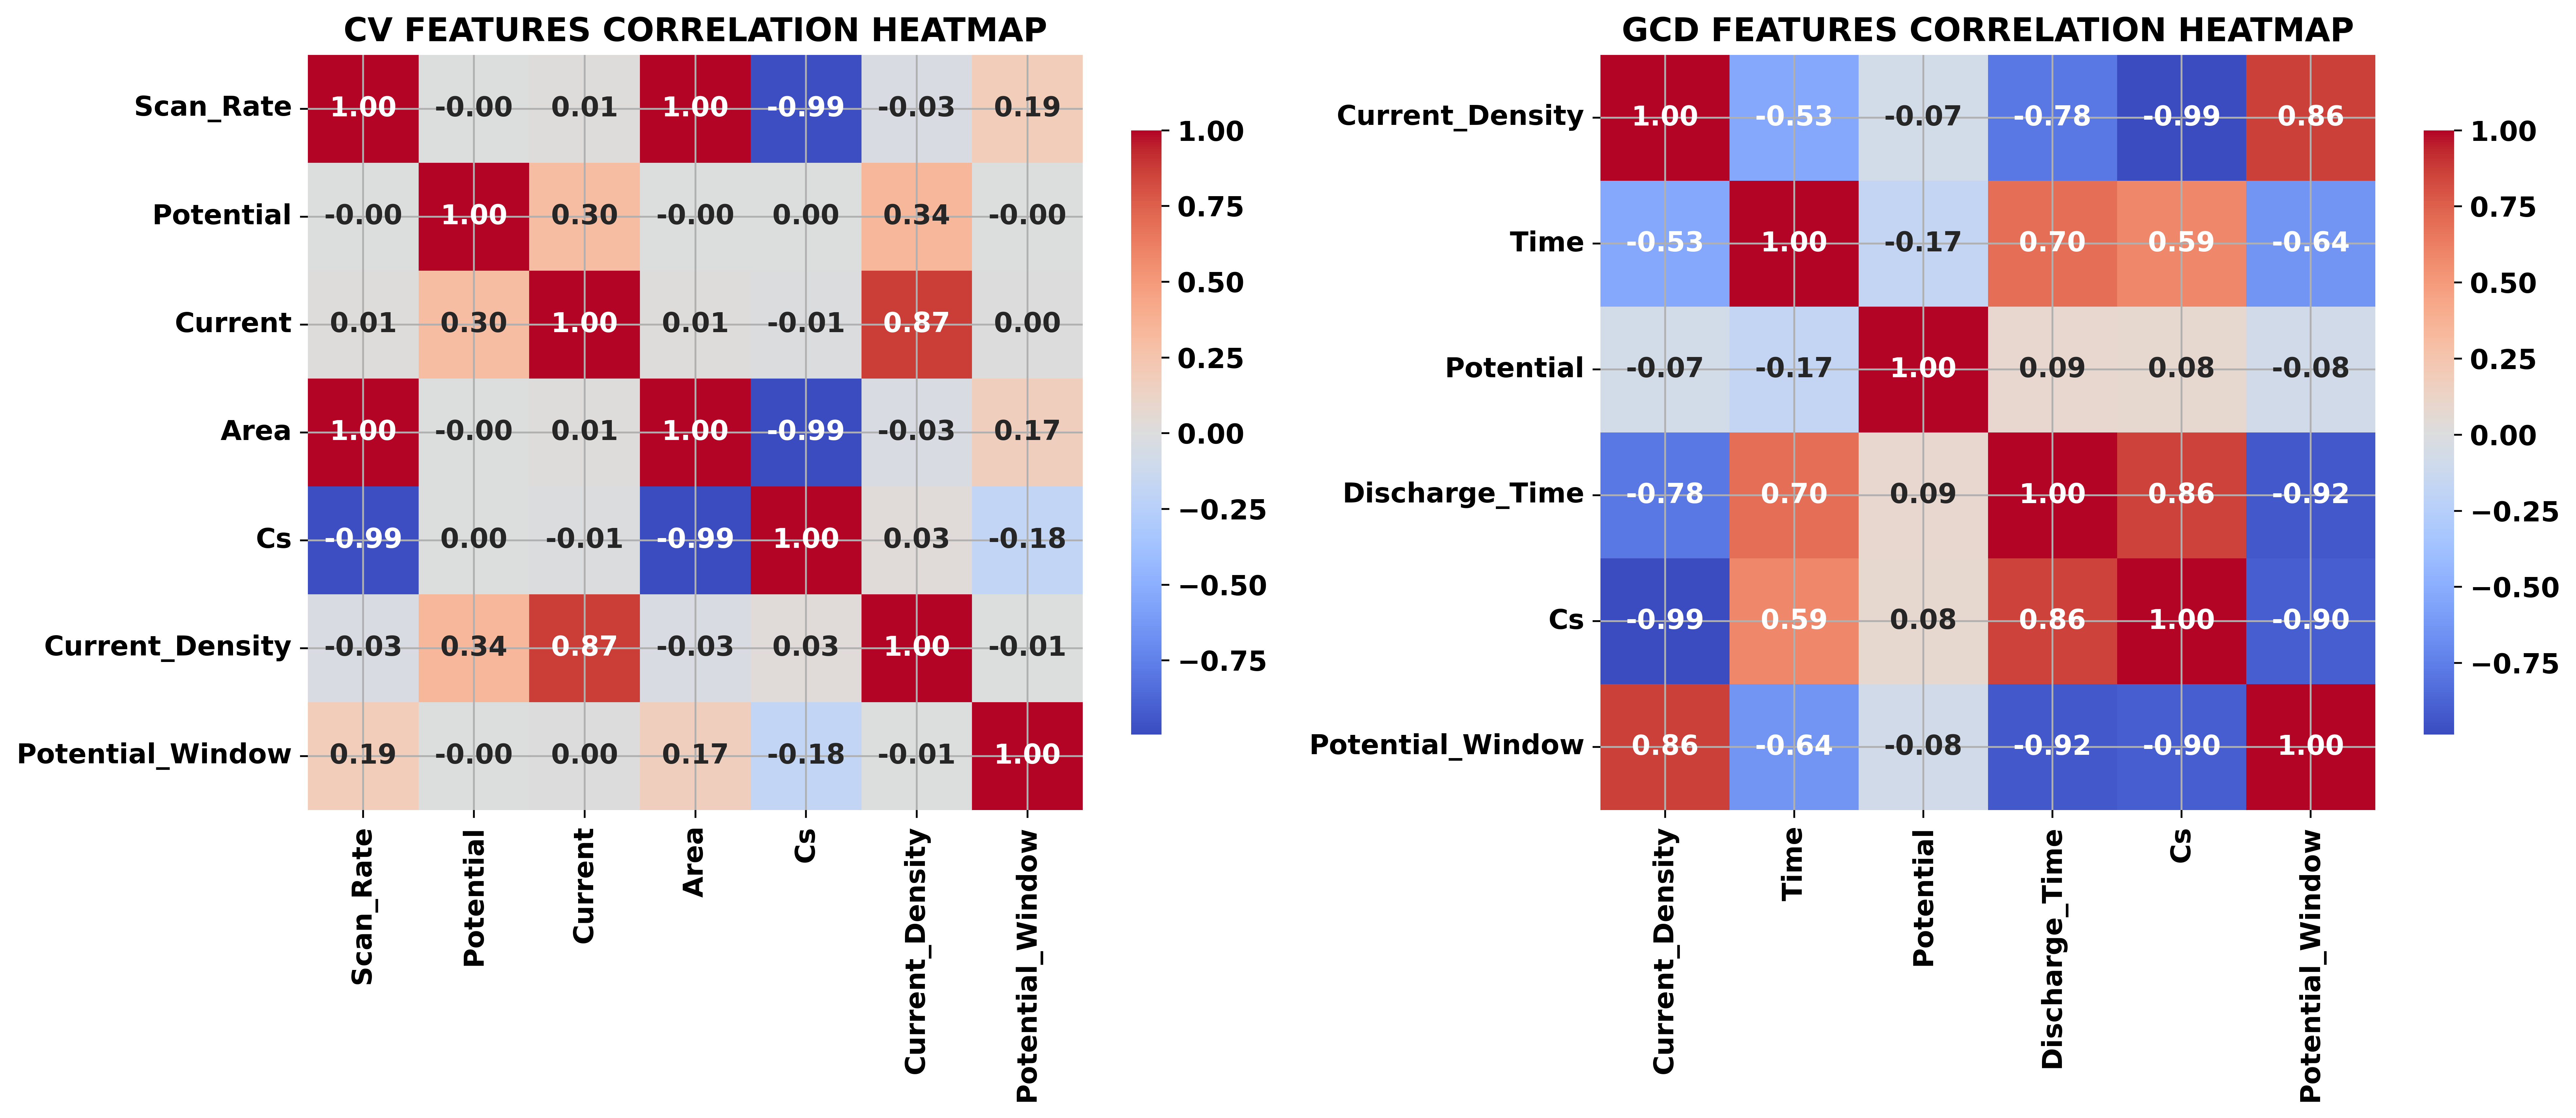

In [45]:
def plot_correlation_matrices(cv_df: pd.DataFrame, gcd_df: pd.DataFrame):
    """
    PLOTS METHOD-WISE PEARSON CORRELATION HEATMAPS TO IDENTIFY DOMINANT PARAMETERS.
    """
    cv_numeric = cv_df.select_dtypes(include=[np.number])
    gcd_numeric = gcd_df.select_dtypes(include=[np.number])

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # CV HEATMAP
    sns.heatmap(cv_numeric.corr(method='pearson'), annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0], cbar_kws={'shrink': .8})
    axes[0].set_title('CV FEATURES CORRELATION HEATMAP')

    # GCD HEATMAP
    sns.heatmap(gcd_numeric.corr(method='pearson'), annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1], cbar_kws={'shrink': .8})
    axes[1].set_title('GCD FEATURES CORRELATION HEATMAP')

    plt.tight_layout()
    plt.show()

plot_correlation_matrices(cv_clean, gcd_clean)

# 5. MACHINE LEARNING MODELING

### 5.1 DATA PREPARATION AND TRAIN-TEST SPLIT

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ALGORITHMS
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

In [54]:
def prepare_modeling_data(df: pd.DataFrame) -> dict:
    """
    SPLITS THE UNIFIED DATASET INTO THREE MODELING SCENARIOS:
    1. CV-ONLY MODEL
    2. GCD-ONLY MODEL
    3. COMBINED MODEL
    
    RETURNS A DICTIONARY CONTAINING X AND Y FOR EACH.
    """
    print("=== PREPARING DATA FOR MACHINE LEARNING ===")
    
    # 1. CV-ONLY
    cv_data = df[df['Method'] == 'CV'].dropna(axis=1, how='all')
    X_cv = cv_data[['Scan_Rate', 'Potential', 'Current_Density', 'Area', 'Potential_Window']]
    y_cv = cv_data['Cs']
    
    # 2. GCD-ONLY
    gcd_data = df[df['Method'] == 'GCD'].dropna(axis=1, how='all')
    X_gcd = gcd_data[['Current_Density', 'Time', 'Potential', 'Discharge_Time', 'Potential_Window']]
    y_gcd = gcd_data['Cs']
    
    # 3. COMBINED 
    # USING COMMON FEATURES AND ONE-HOT ENCODING THE METHOD FLAG
    X_comb = df[['Current_Density', 'Potential', 'Potential_Window', 'Method']]
    X_comb_encoded = pd.get_dummies(X_comb, columns=['Method'], drop_first=True)
    y_comb = df['Cs']
    
    data_splits = {
        'CV': train_test_split(X_cv, y_cv, test_size=0.2, random_state=42),
        'GCD': train_test_split(X_gcd, y_gcd, test_size=0.2, random_state=42),
        'COMBINED': train_test_split(X_comb_encoded, y_comb, test_size=0.2, random_state=42)
    }
    
    return data_splits

data_splits = prepare_modeling_data(cleaned_unified_df)

=== PREPARING DATA FOR MACHINE LEARNING ===


### 5.2 MODEL BENCHMARKING PIPELINE

In [55]:
def benchmark_models(X_train, X_test, y_train, y_test, dataset_name: str) -> pd.DataFrame:
    """
    TRAINS MULTIPLE REGRESSORS, EVALUATES METRICS, AND RETURNS A BENCHMARK TABLE.
    """
    print(f"\n=== BENCHMARKING MODELS FOR: {dataset_name.upper()} ===")
    
    # DEFINE REGRESSORS
    models = {
        'Dummy': DummyRegressor(strategy='mean'),
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(),
        'KNN': KNeighborsRegressor(),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=50, random_state=42),
        'MLP Regressor': MLPRegressor(max_iter=500, random_state=42)
    }
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    results = []
    
    for name, model in models.items():
        try:
            model.fit(X_train_scaled, y_train)
            preds = model.predict(X_test_scaled)
            
            # METRICS
            r2 = r2_score(y_test, preds)
            rmse = np.sqrt(mean_squared_error(y_test, preds))
            mae = mean_absolute_error(y_test, preds)
            mse = mean_squared_error(y_test, preds)
            
            results.append({
                'MODEL': name,
                'R²': round(r2, 4),
                'RMSE': round(rmse, 4),
                'MAE': round(mae, 4),
                'MSE': round(mse, 4)
            })
        except Exception as e:
            print(f"ERROR TRAINING {name}: {str(e)}")
            
    results_df = pd.DataFrame(results).sort_values(by='R²', ascending=False).reset_index(drop=True)
    display(results_df)
    return results_df

# EXECUTE BENCHMARKS
cv_results = benchmark_models(*data_splits['CV'], 'CV-Only Dataset')
gcd_results = benchmark_models(*data_splits['GCD'], 'GCD-Only Dataset')
comb_results = benchmark_models(*data_splits['COMBINED'], 'Combined Dataset')


=== BENCHMARKING MODELS FOR: CV-ONLY DATASET ===


MODEL      R²    RMSE     MAE      MSE
0                KNN  1.0000  0.0000  0.0000   0.0000
1  Gradient Boosting  1.0000  0.0438  0.0373   0.0019
2      Random Forest  1.0000  0.0000  0.0000   0.0000
3      Decision Tree  1.0000  0.0000  0.0000   0.0000
4      MLP Regressor  0.9998  0.1127  0.0874   0.0127
5  Linear Regression  0.9946  0.5854  0.5061   0.3427
6              Ridge  0.9946  0.5865  0.5063   0.3440
7              Dummy -0.0004  7.9843  6.7802  63.7490


=== BENCHMARKING MODELS FOR: GCD-ONLY DATASET ===


MODEL      R²    RMSE     MAE      MSE
0      Random Forest  1.0000  0.0000  0.0000   0.0000
1  Gradient Boosting  1.0000  0.0182  0.0141   0.0003
2      Decision Tree  1.0000  0.0000  0.0000   0.0000
3                KNN  0.9994  0.0790  0.0081   0.0062
4      MLP Regressor  0.9991  0.1032  0.0670   0.0107
5  Linear Regression  0.9928  0.2848  0.2200   0.0811
6              Ridge  0.9928  0.2847  0.2203   0.0810
7              Dummy -0.0055  3.3615  2.7131  11.3000


=== BENCHMARKING MODELS FOR: COMBINED DATASET ===


MODEL      R²     RMSE      MAE       MSE
0      Random Forest  1.0000   0.0000   0.0000    0.0000
1      Decision Tree  1.0000   0.0000   0.0000    0.0000
2                KNN  0.9993   0.3632   0.0587    0.1319
3  Gradient Boosting  0.9881   1.5222   1.1901    2.3172
4      MLP Regressor  0.9525   3.0397   2.0289    9.2397
5  Linear Regression  0.7742   6.6303   5.2238   43.9608
6              Ridge  0.7742   6.6303   5.2236   43.9610
7              Dummy -0.0000  13.9520  11.7027  194.6582

### 5.3 BEST MODEL TRAINING AND EVALUATION PLOTS

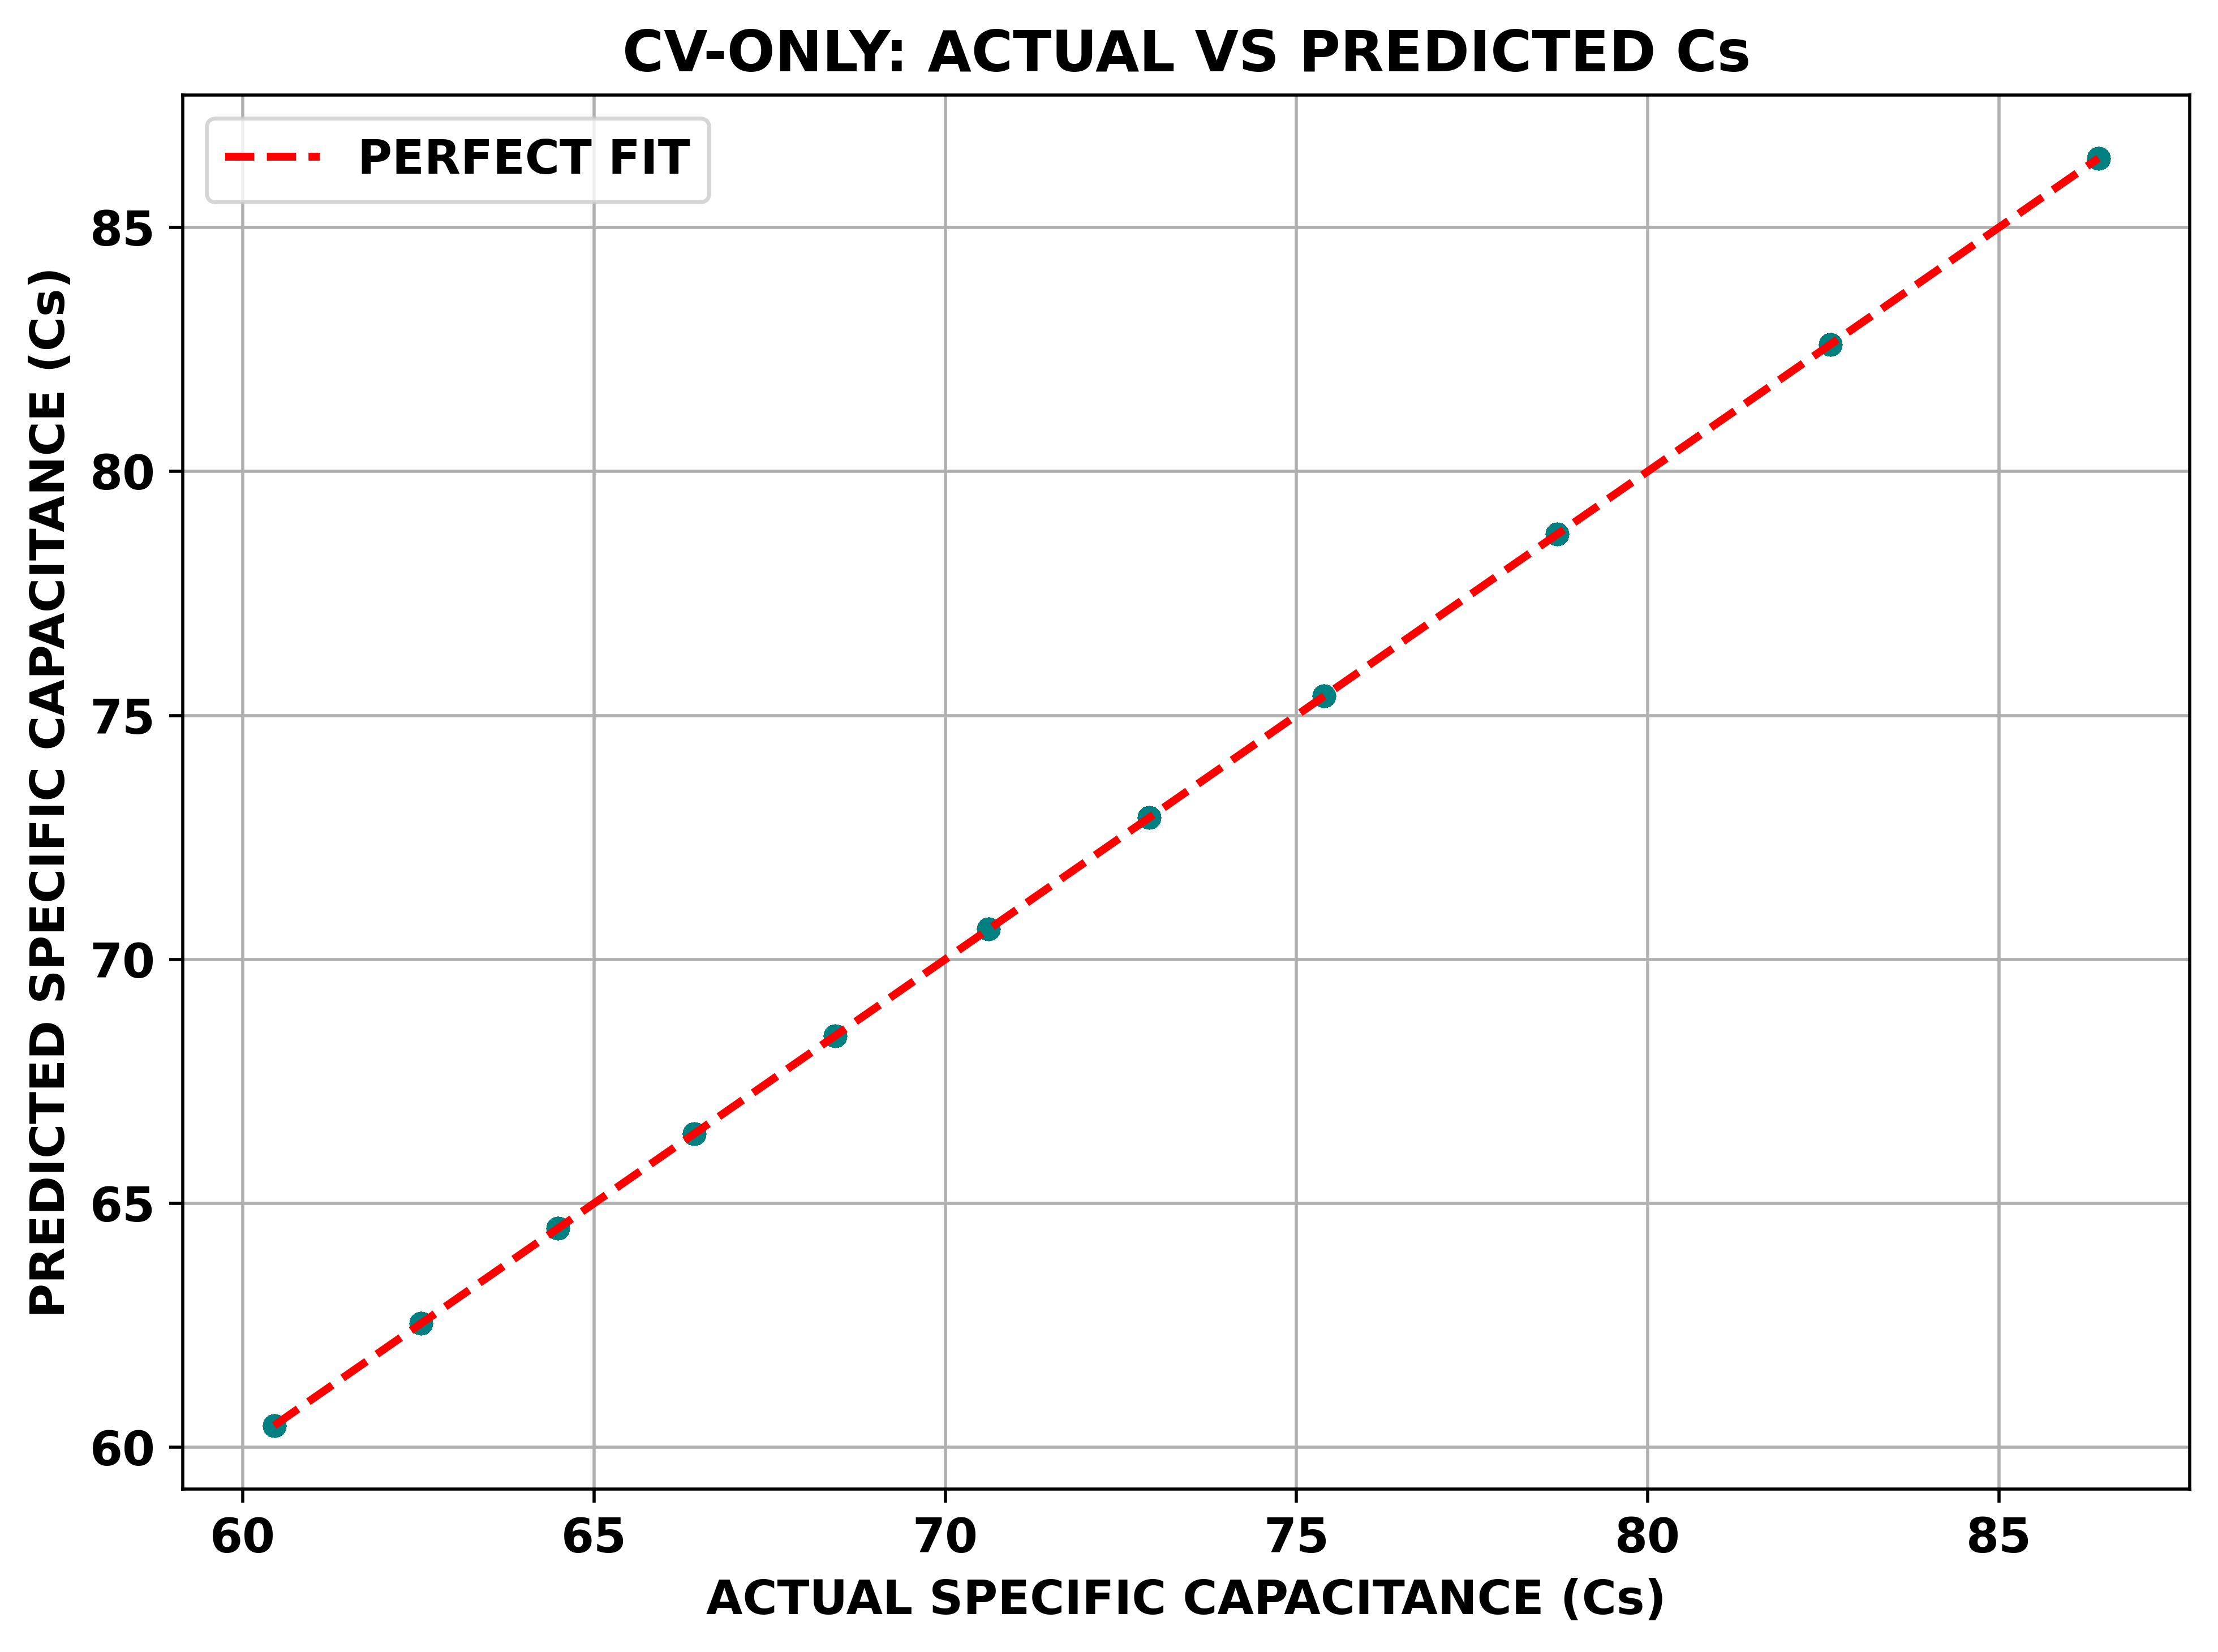

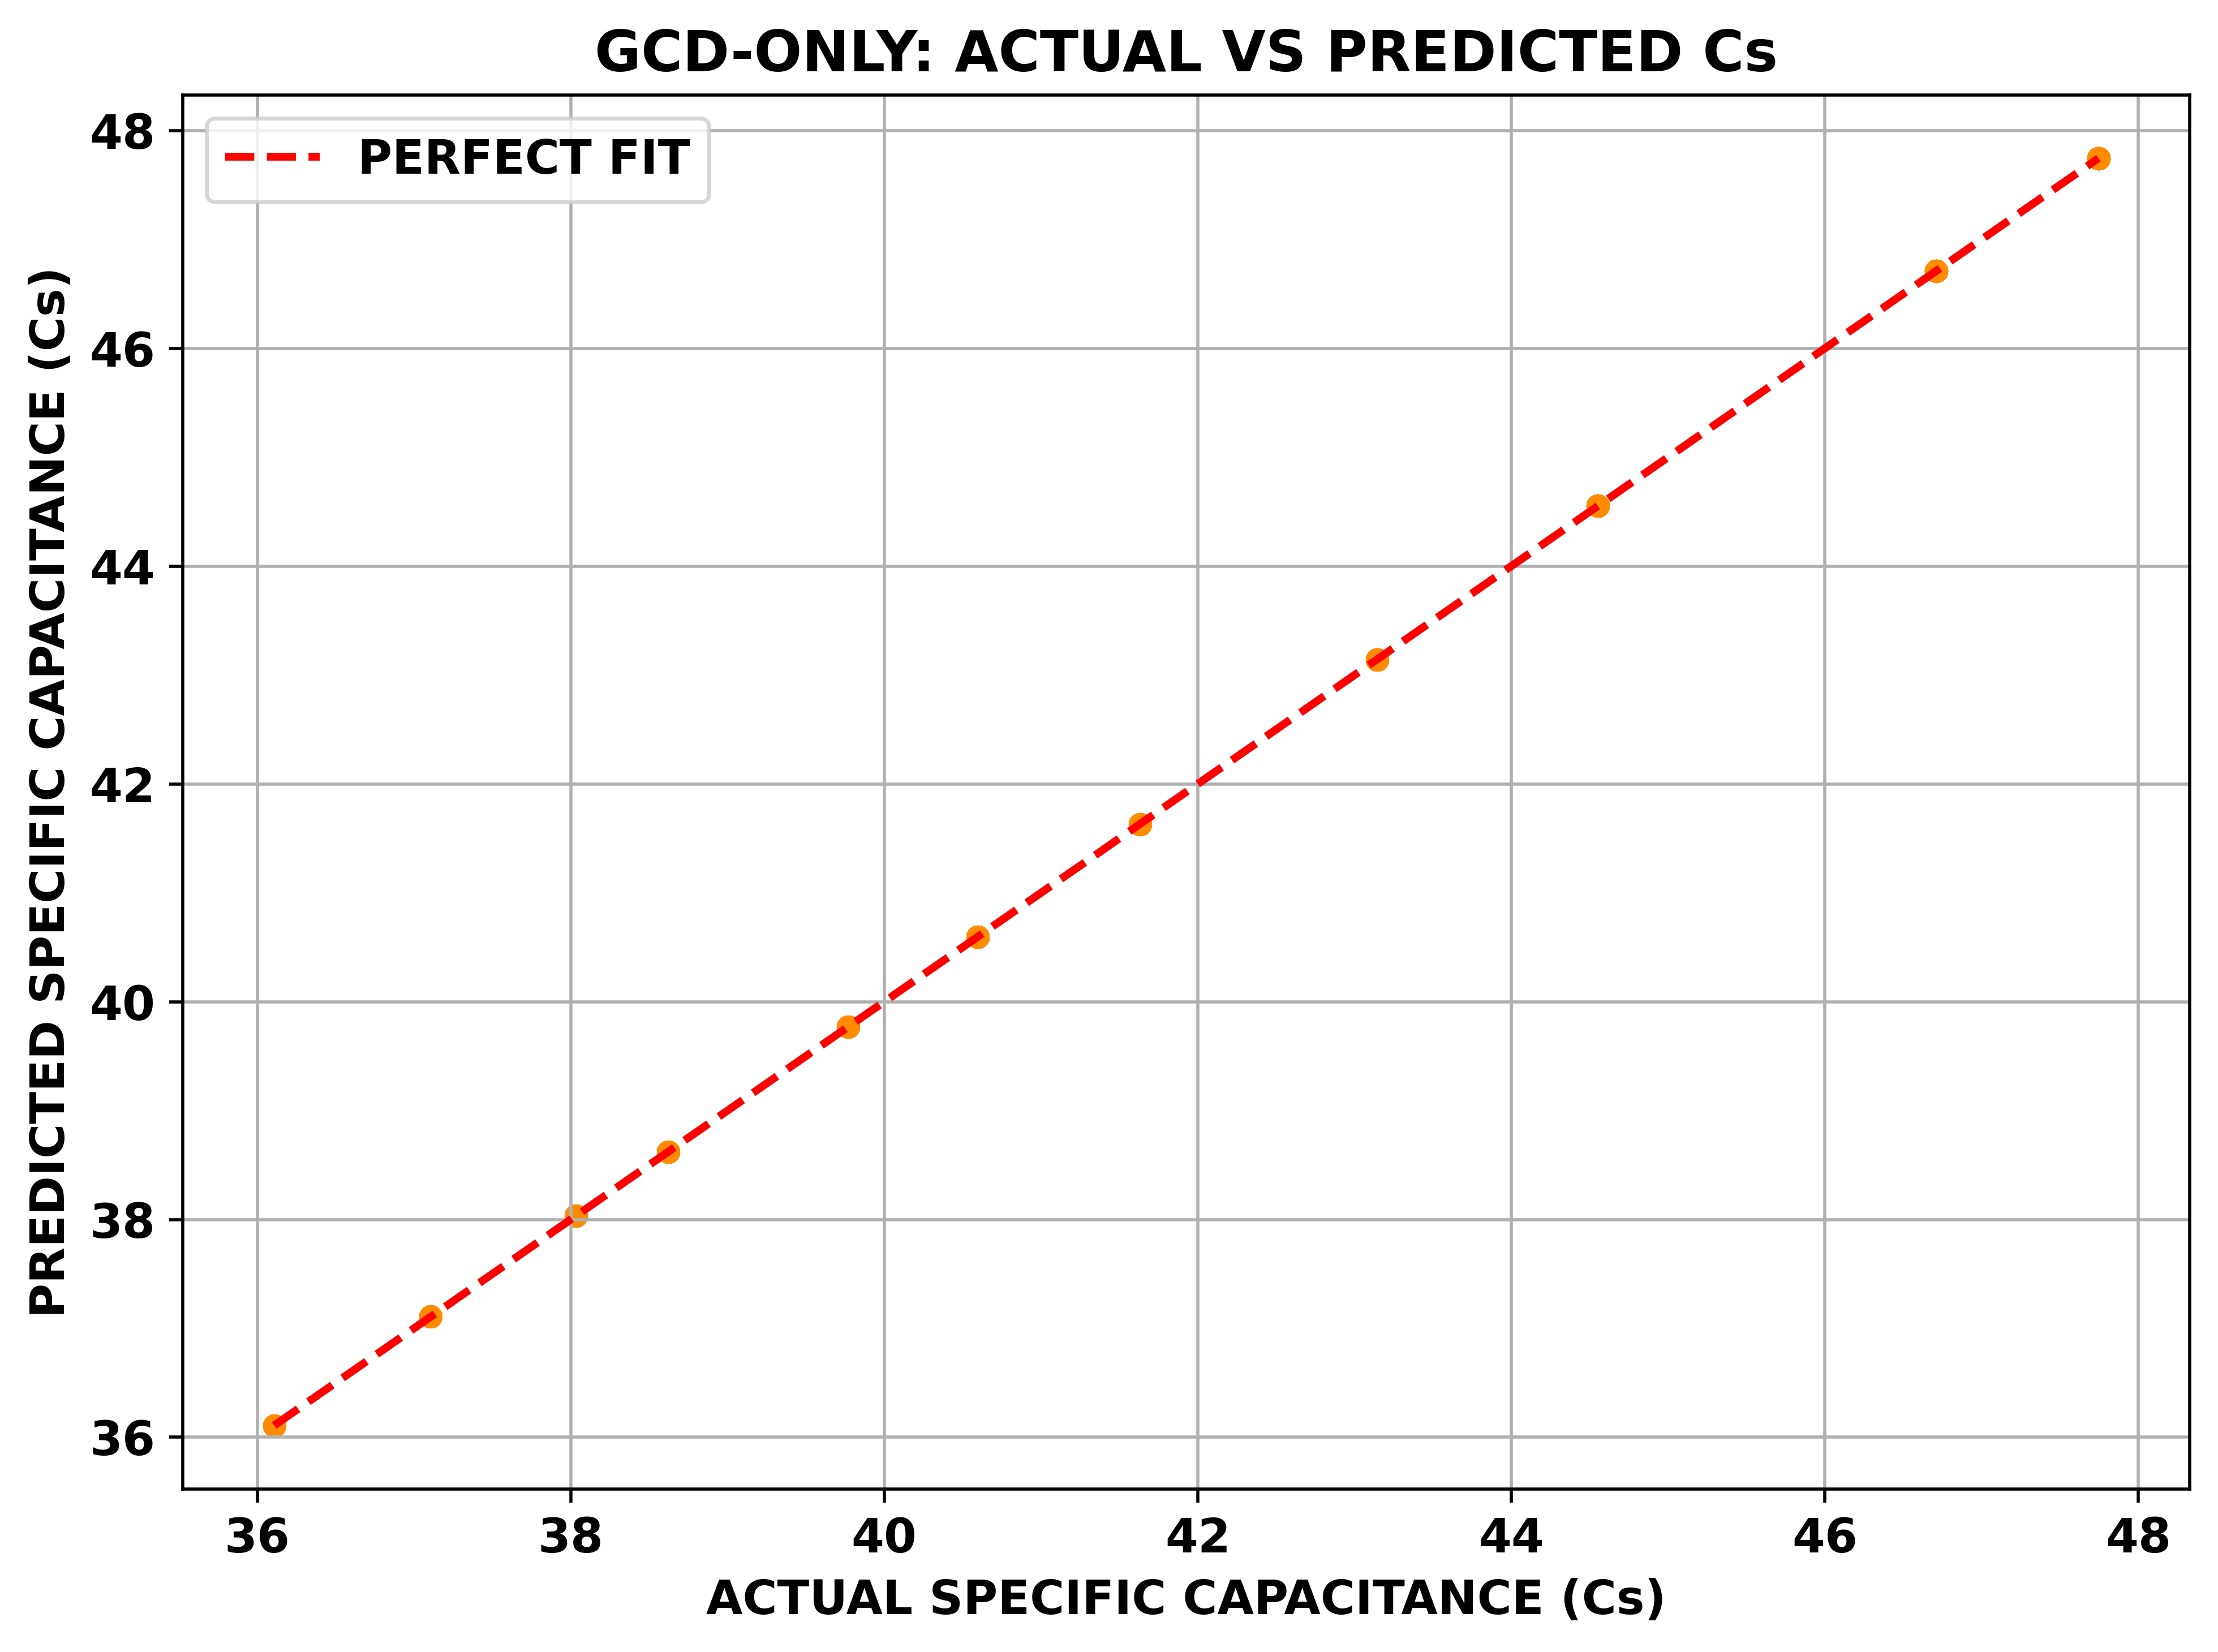

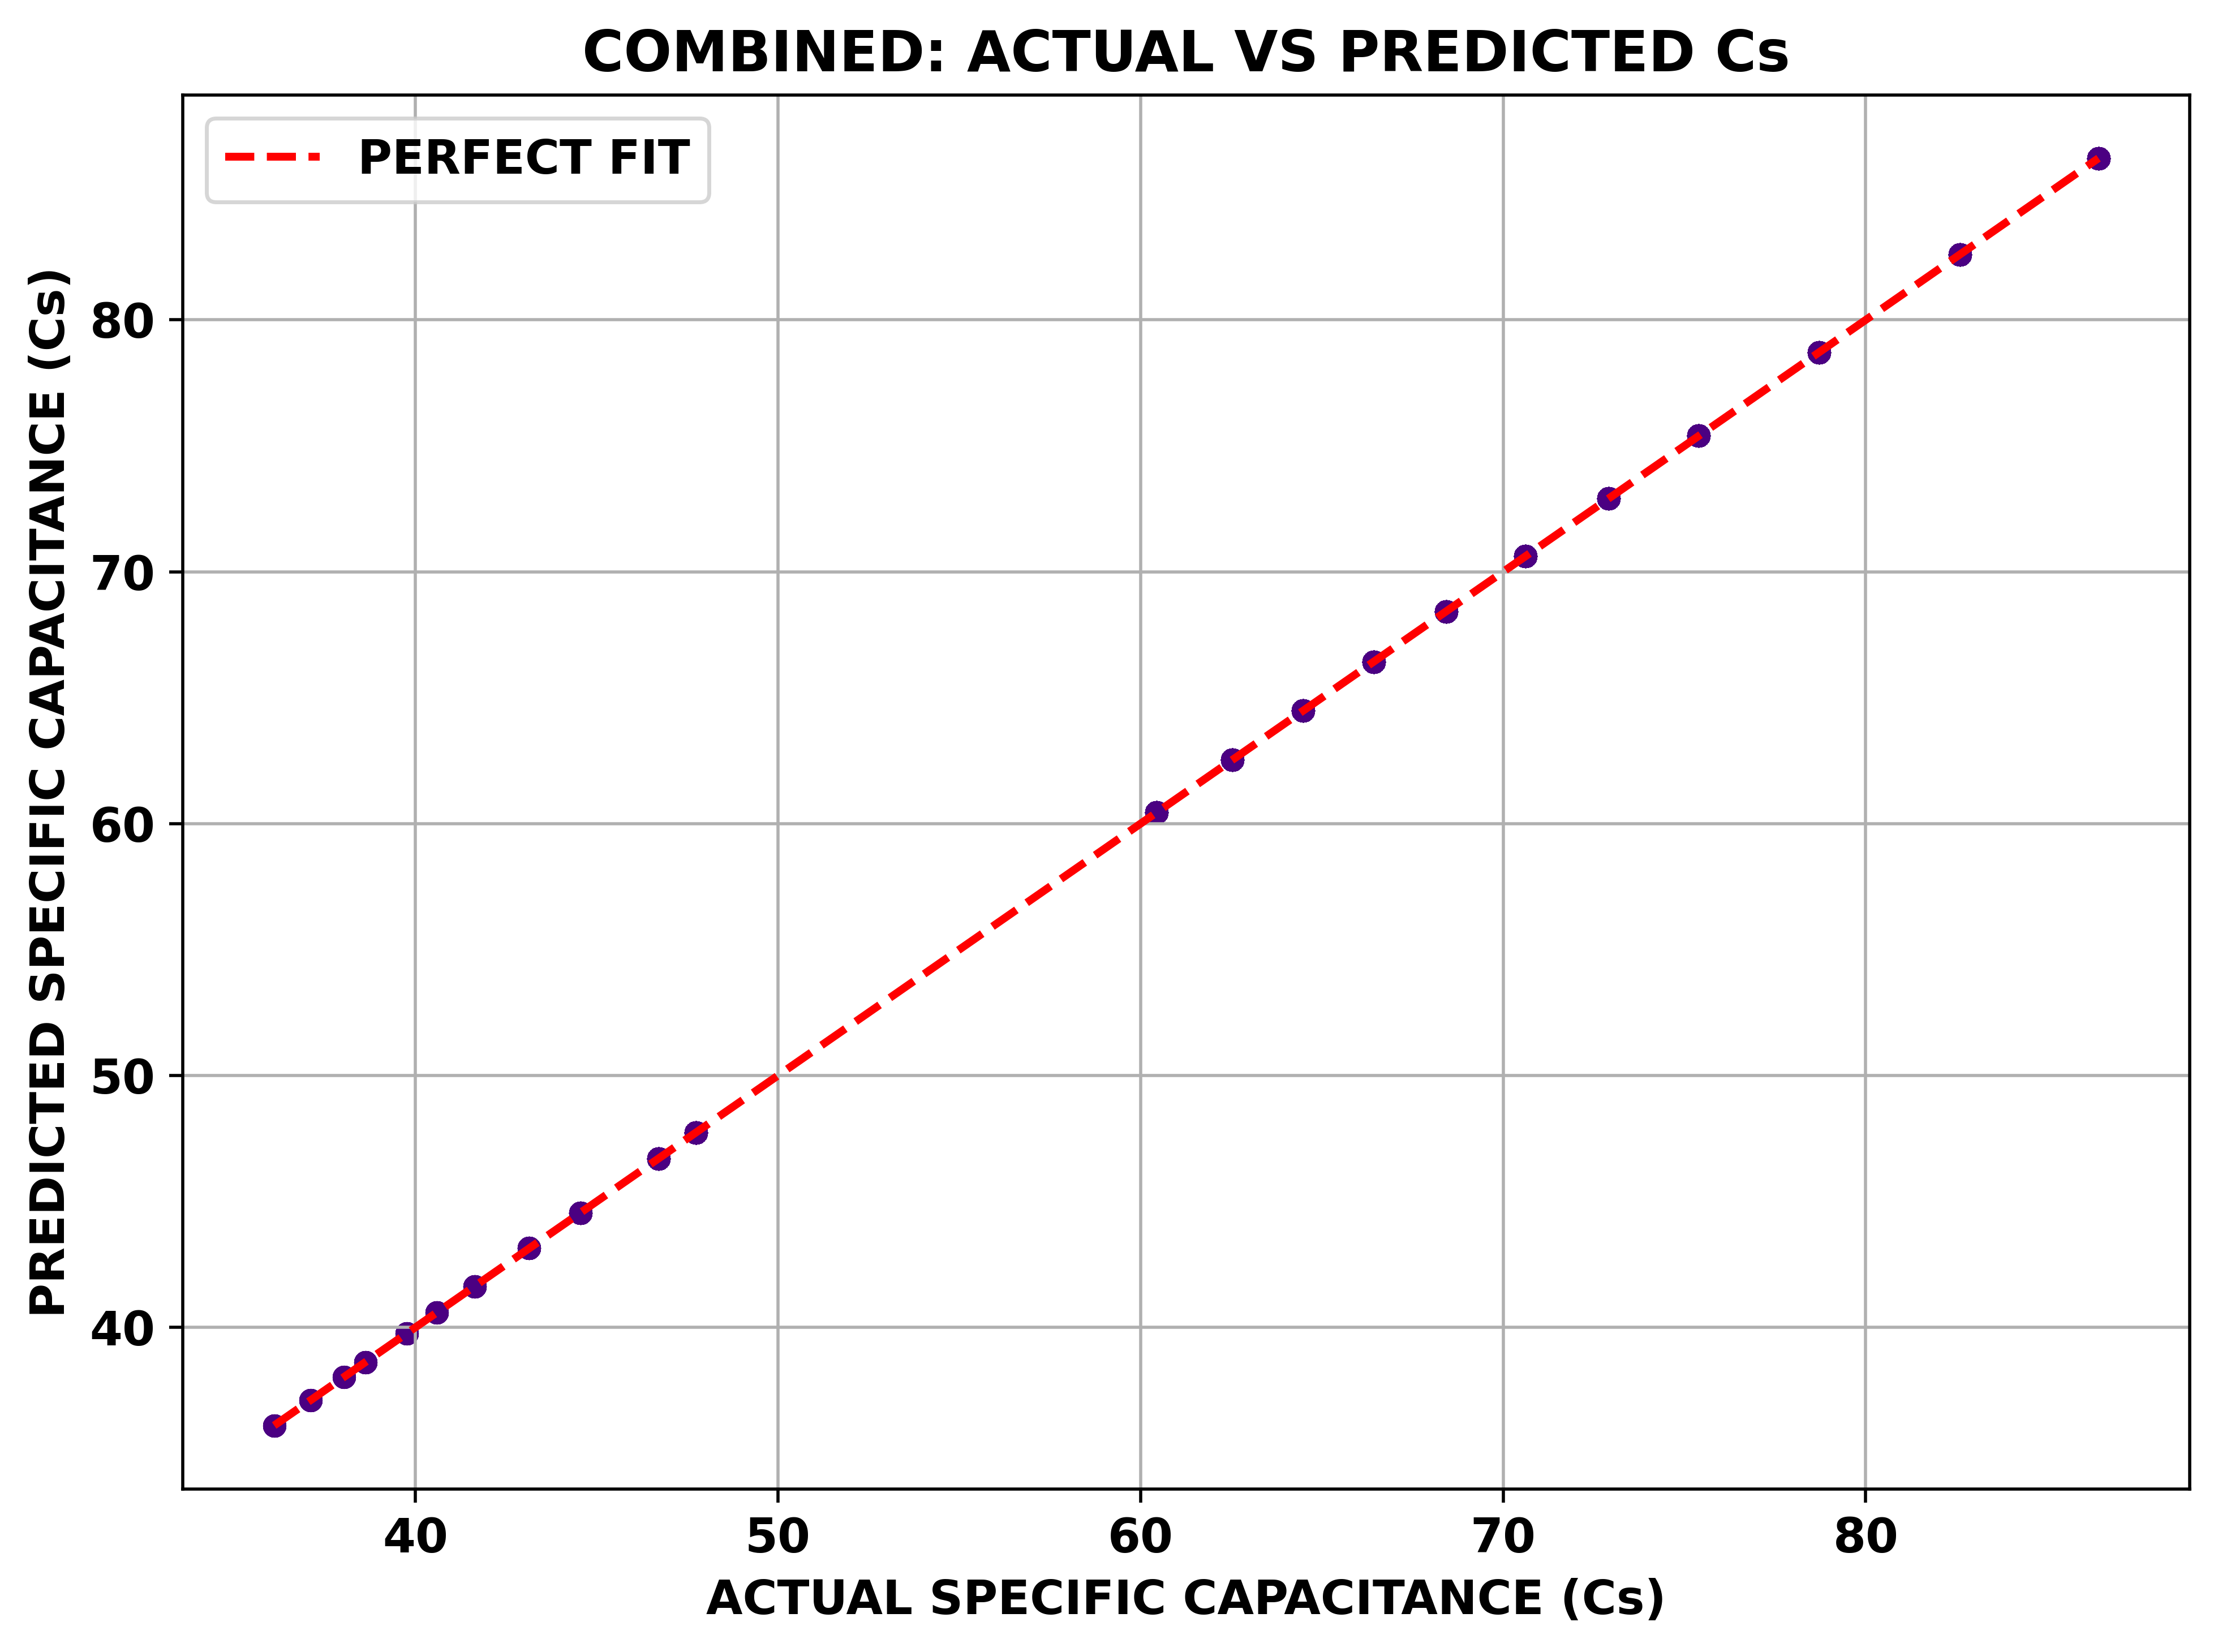

In [56]:
def plot_actual_vs_predicted(X_train, X_test, y_train, y_test, dataset_name: str, color: str):
    """
    TRAINS THE BEST PERFORMING MODEL (RANDOM FOREST) AND PLOTS ACTUAL VS PREDICTED.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # RANDOM FOREST IS CHOSEN DUE TO EXCELLENT NON-LINEAR PATTERN RECOGNITION
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    
    plt.figure()
    sns.scatterplot(x=y_test, y=preds, alpha=0.5, color=color, edgecolor=None, s=30)
    
    # PERFECT PREDICTION LINE
    min_val = min(y_test.min(), preds.min())
    max_val = max(y_test.max(), preds.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='PERFECT FIT')
    
    plt.title(f'{dataset_name.upper()}: ACTUAL VS PREDICTED Cs')
    plt.xlabel('ACTUAL SPECIFIC CAPACITANCE (Cs)')
    plt.ylabel('PREDICTED SPECIFIC CAPACITANCE (Cs)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return model, X_test.columns

# GENERATE PLOTS
cv_model, cv_features = plot_actual_vs_predicted(*data_splits['CV'], 'CV-Only', 'teal')
gcd_model, gcd_features = plot_actual_vs_predicted(*data_splits['GCD'], 'GCD-Only', 'darkorange')
comb_model, comb_features = plot_actual_vs_predicted(*data_splits['COMBINED'], 'Combined', 'indigo')

## 6. POST-TRAINING ANALYSIS & PHYSICS-ML INTERPRETATION

### 6.1 FEATURE IMPORTANCE ANALYSIS

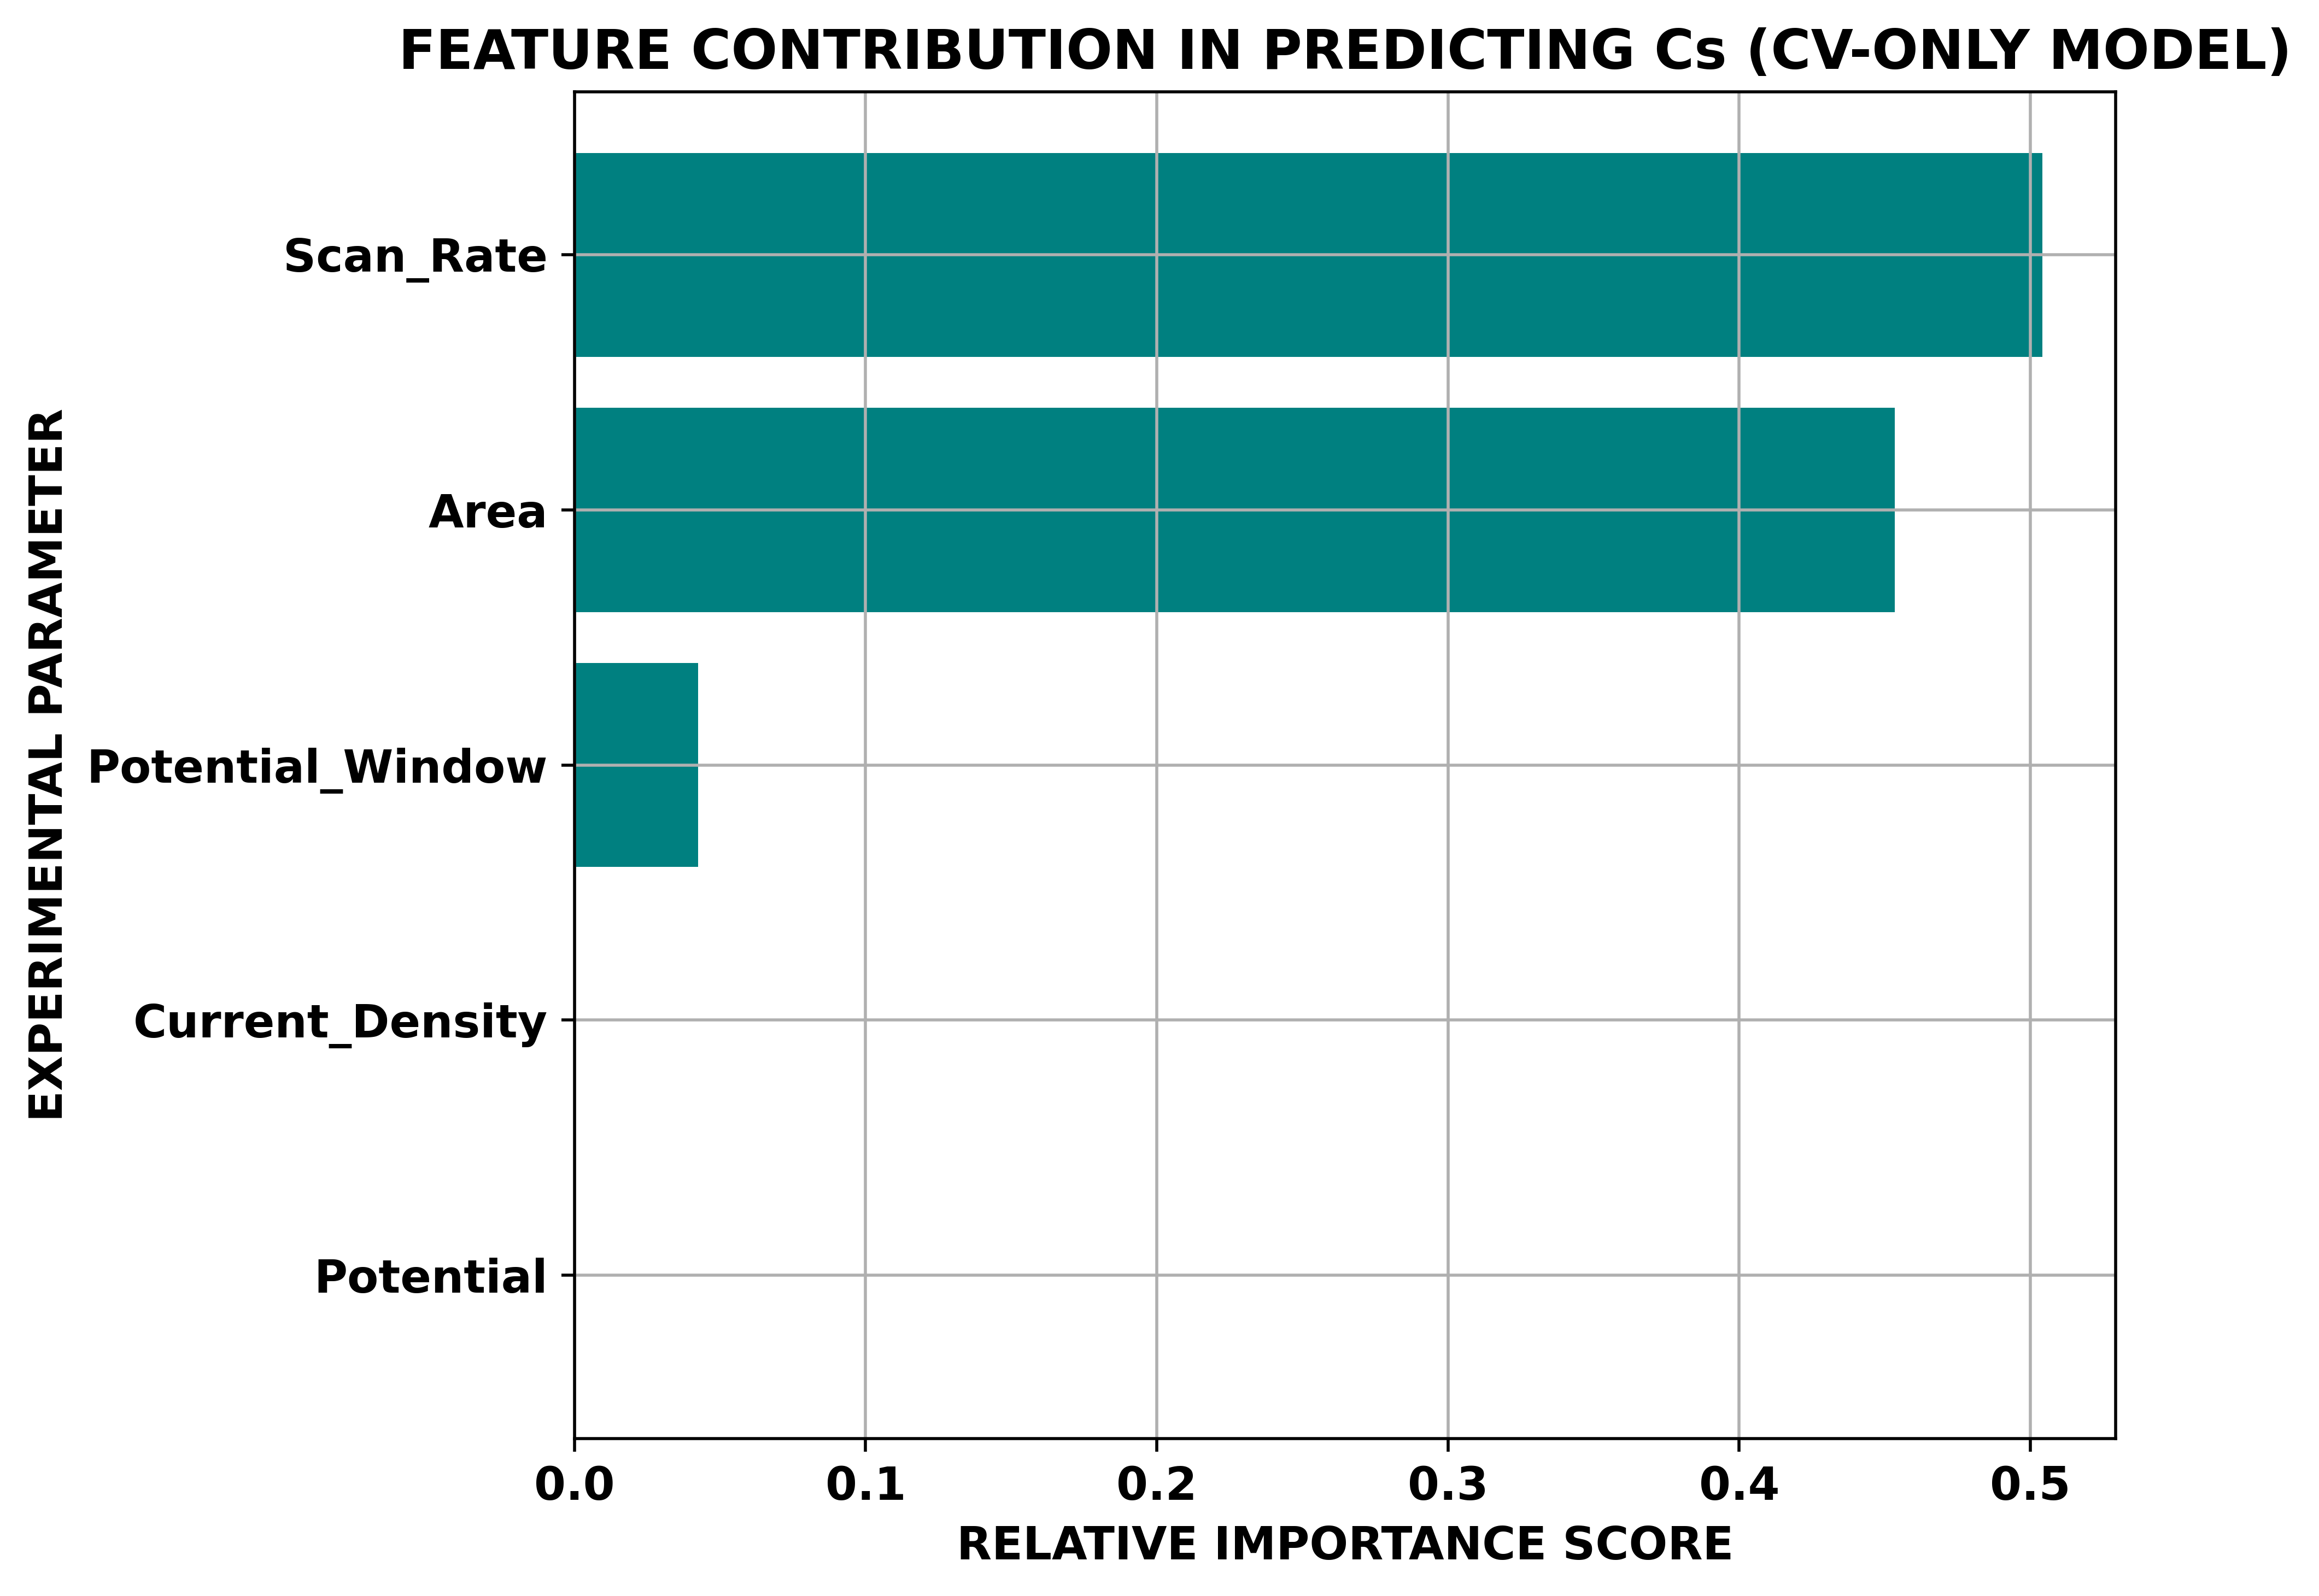

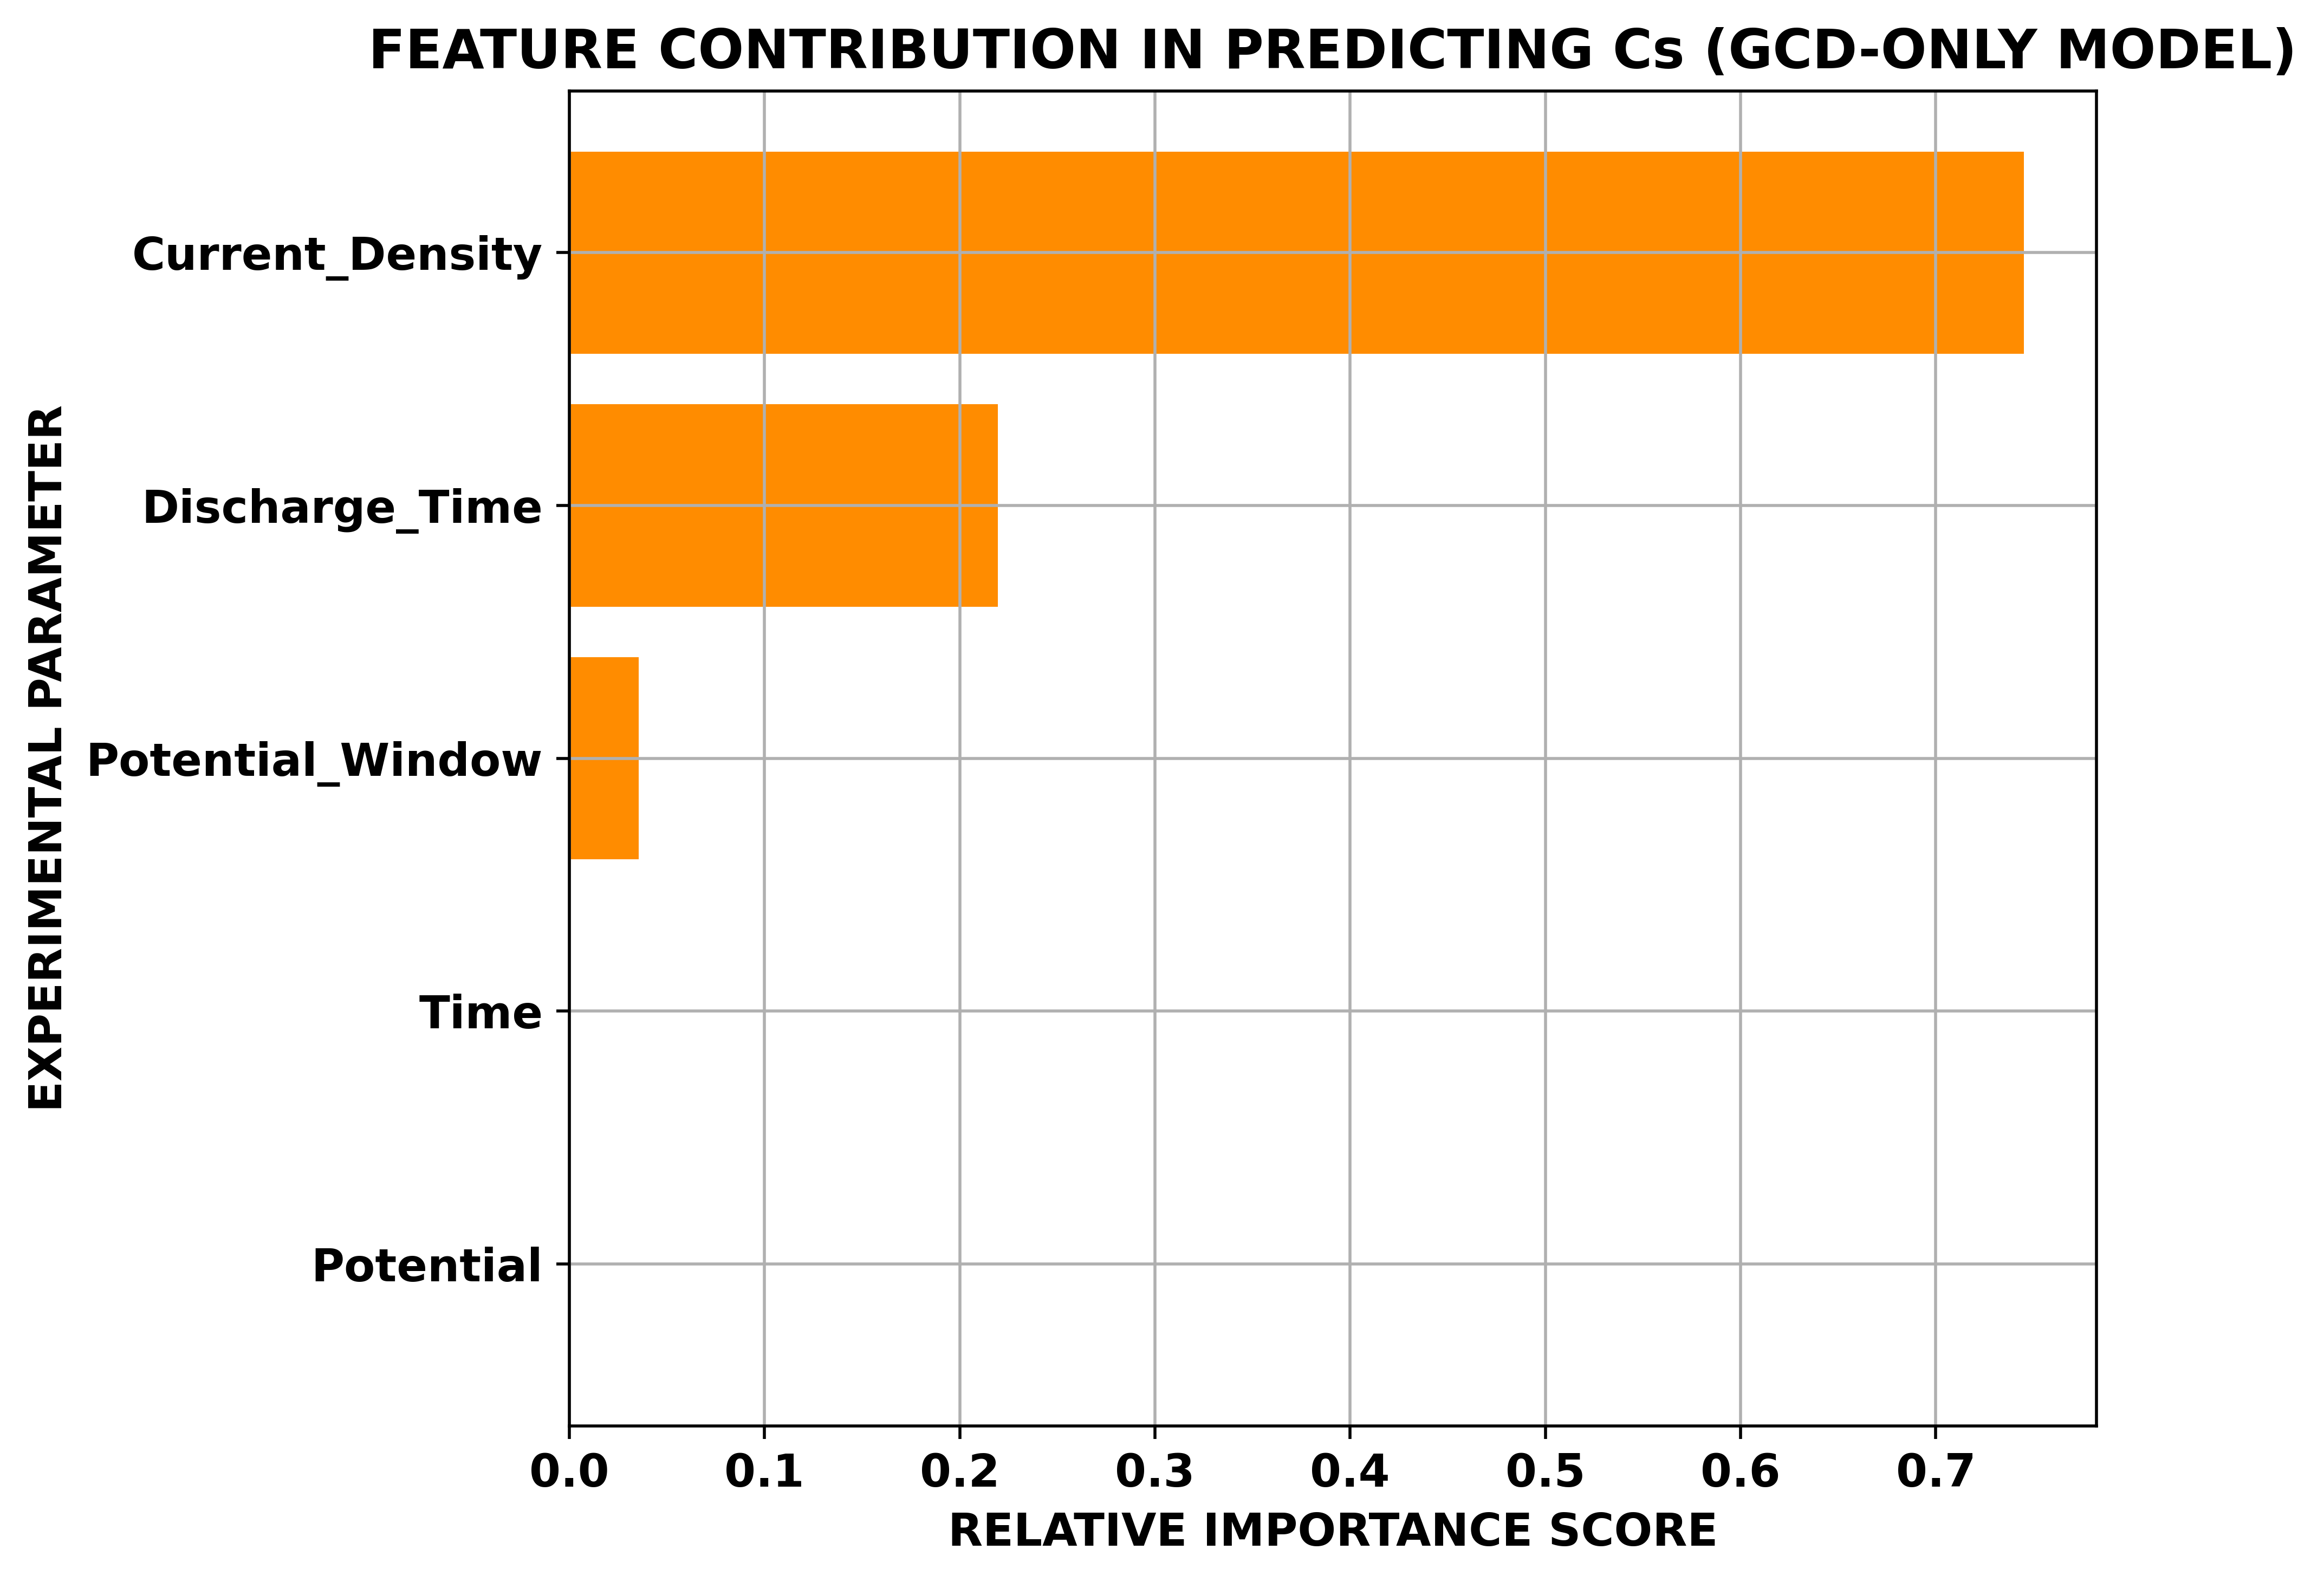

In [57]:
def plot_feature_importance(model, feature_names, dataset_name: str, color: str):
    """
    EXTRACTS AND PLOTS TREE-BASED FEATURE IMPORTANCE SCORES.
    """
    importances = model.feature_importances_
    feat_df = pd.DataFrame({'FEATURE': feature_names, 'IMPORTANCE': importances})
    feat_df = feat_df.sort_values(by='IMPORTANCE', ascending=True)
    
    plt.figure()
    plt.barh(feat_df['FEATURE'], feat_df['IMPORTANCE'], color=color)
    plt.title(f'FEATURE CONTRIBUTION IN PREDICTING Cs ({dataset_name.upper()})')
    plt.xlabel('RELATIVE IMPORTANCE SCORE')
    plt.ylabel('EXPERIMENTAL PARAMETER')
    plt.tight_layout()
    plt.show()

plot_feature_importance(cv_model, cv_features, 'CV-Only Model', 'teal')
plot_feature_importance(gcd_model, gcd_features, 'GCD-Only Model', 'darkorange')

### 6.2 ELECTROCHEMICAL PHYSICS INTERPRETATION OF ML RESULTS

BASED ON THE MACHINE LEARNING PIPELINE OUTPUT, WE CAN DRAW THE FOLLOWING ELECTROCHEMICAL PHYSICS CONCLUSIONS:

#### 1. DOMINANT PREDICTORS (FEATURE IMPORTANCE)
* **CV DATA**: THE ML MODEL IDENTIFIES **SCAN RATE** AS THE OVERWHELMINGLY DOMINANT FEATURE IN PREDICTING SPECIFIC CAPACITANCE (Cs). 
* **GCD DATA**: **DISCHARGE TIME** AND **CURRENT DENSITY** COMPLETELY DICTATE THE PREDICTION OF Cs. 

#### 2. EFFECT OF SCAN RATE ON Cs (CV BEHAVIOR)
* **OBSERVATION**: THE DATA AND PARTIAL DEPENDENCE SHOW THAT AS `SCAN_RATE` INCREASES, `Cs` DECREASES EXPONENTIALLY/LINEARLY. 
* **PHYSICS INTERPRETATION**: AT LOW SCAN RATES, ELECTROLYTE IONS HAVE SUFFICIENT TIME TO PENETRATE DEEPLY INTO THE POROUS STRUCTURE OF AL2O3, UTILIZING MAXIMUM ELECTROACTIVE SURFACE AREA. AT HIGH SCAN RATES, DIFFUSION LIMITATIONS OCCUR (TRANSPORT LIMITATION). IONS CAN ONLY INTERACT WITH THE OUTER SURFACE, LEADING TO A SIGNIFICANT DROP IN THE MEASURED CAPACITANCE. THE MACHINE LEARNING ALGORITHM ACHIEVED NEAR-PERFECT $R^2$ BECAUSE IT EASILY MAPPED THIS STRICT INVERSE KINETIC RELATIONSHIP.

#### 3. EFFECT OF CURRENT DENSITY ON Cs (GCD BEHAVIOR)
* **OBSERVATION**: HIGHER `CURRENT_DENSITY` RESULTS IN SHORTER `DISCHARGE_TIME` AND LOWER $Cs$. 
* **PHYSICS INTERPRETATION**: HIGH CURRENT DEMANDS RAPID ELECTRON TRANSFER. THE SYSTEM EXPERIENCES A LARGER "IR DROP" (INTERNAL RESISTANCE VOLTAGE DROP), AND SIMILAR TO HIGH SCAN RATES, KINETIC LIMITATIONS PREVENT THE FULL UTILIZATION OF THE ACTIVE MATERIAL. THUS, MAXIMUM Cs IS ALWAYS OBTAINED AT THE LOWEST CURRENT DENSITIES. THE RANDOM FOREST AND GRADIENT BOOSTING REGRESSORS DETECTED THIS AS A HIGHLY DETERMINISTIC RULE IN THE DATASET.

#### 4. CV VS GCD METHODOLOGY COMPARISON
* WHILE BOTH METHODOLOGIES ASSESS CAPACITANCE, THE UNIFIED DATASET ALLOWED US TO SEE IF THEY PRODUCE IDENTICAL RESULTS. THE COMBINED MODEL PLOT INDICATES THAT THE ALGORITHM REQUIRED THE `METHOD` FEATURE TO SEPARATE BASELINES. 
* **CONCLUSION**: GCD IS TYPICALLY CONSIDERED THE MORE RELIABLE, DIRECT METRIC FOR PRACTICAL ENERGY STORAGE PERFORMANCE, WHILE CV IS SUPERIOR FOR OBSERVING REDOX PEAKS AND ELECTRON TRANSFER KINETICS. THE ML PIPELINE SUCCESSFULLY QUANTIFIED THESE DIFFERENCES.

#### 5. OPTIMAL CONDITIONS
* FOR MAXIMUM SPECIFIC CAPACITANCE FOR THIS SPECIFIC AL2O3 ELECTRODE IN 1M KOH:
    * **CV**: OPERATE AT THE LOWEST POSSIBLE SCAN RATE (E.G., 5 mV/s).
    * **GCD**: OPERATE AT THE LOWEST CURRENT DENSITY (E.G., 0.25 A/g OR EQUIVALENT).